In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix

2025-06-01 02:23:50.115928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748733830.133750   26342 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748733830.139517   26342 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748733830.152998   26342 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748733830.153015   26342 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748733830.153017   26342 computation_placer.cc:177] computation placer alr

In [2]:
# Constants
IMG_SIZE = (320, 320)
BATCH_SIZE = 8
EPOCHS = 200
DATA_PATH = "../dsTest"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VALID_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")


In [3]:
# Load Data
def load_data_from_directory(base_path):
    image_paths = []
    labels = []
    class_names = {"not fractured": 0, "fractured": 1}
    for label_name in class_names:
        folder_path = os.path.join(base_path, label_name)
        for fname in os.listdir(folder_path):
            if fname.endswith((".png", ".jpg", ".jpeg")) and not fname.startswith("._"):
                image_paths.append(os.path.join(folder_path, fname))
                labels.append(class_names[label_name])
    return np.array(image_paths), np.array(labels)

In [4]:
# Load data
train_image_paths, train_labels = load_data_from_directory(TRAIN_PATH)
valid_image_paths, valid_labels = load_data_from_directory(VALID_PATH)
test_image_paths, test_labels = load_data_from_directory(TEST_PATH)

In [5]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

Class Weights: {0: 0.9963362068965518, 1: 1.0036908380373426}


In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [7]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import preprocess_input
import numpy as np
import cv2

class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, class_weights, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.class_weights = class_weights
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__data_generation(batch_paths, batch_labels)
        sample_weights = np.array([self.class_weights[label] for label in y])

        return X, y, sample_weights


    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

    def __data_generation(self, batch_paths, batch_labels):
        images = []
        valid_labels = []
        for path, label in zip(batch_paths, batch_labels):
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read image {path}, skipping...")
                continue  # Skip this image
            img = cv2.resize(img, self.img_size)
            img = img / 255.0  # Normalize
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            if self.augment:
                img = self.datagen.random_transform(img)
            images.append(img)
            valid_labels.append(label)

        # If no valid images in batch, raise error or handle it gracefully
        if len(images) == 0:
            raise ValueError("No valid images found in batch.")

        return np.array(images), np.array(valid_labels)



In [8]:
# Final Generator Initialization (No splitting)
train_generator = MURADataGenerator(
    train_image_paths, train_labels,
    class_weights=class_weights,
    augment=True,
    shuffle=True
)

valid_generator = MURADataGenerator(
    valid_image_paths, valid_labels,
    class_weights=class_weights,
    augment=False,
    shuffle=False
)

test_generator = MURADataGenerator(
    test_image_paths, test_labels,
    class_weights=class_weights,
    augment=False,
    shuffle=False
)


In [9]:
# Load Pretrained Model
base_model = DenseNet169(weights='imagenet', include_top=False, input_tensor=Input(shape=(*IMG_SIZE, 3)))


I0000 00:00:1748715779.537431   10496 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
# Gradually Unfreeze Layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

In [11]:
# Add Custom Classifier Head
x = Flatten()(base_model.output)
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)


In [12]:
# Compile Model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Changed to False for ensembling
model_checkpoint = ModelCheckpoint(
    "model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [14]:

# Train Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)
I0000 00:00:1748715799.432758   10527 service.cc:152] XLA service 0x7f09fc0041a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748715799.432774   10527 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-05-31 21:23:20.011897: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748715803.728116   10527 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-31 21:23:26.038033: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_

  82/1156 ━━━━━━━━━━━━━━━━━━━━ 3:03 171ms/step - accuracy: 0.6416 - loss: 5.4355

Premature end of JPEG file


 159/1156 ━━━━━━━━━━━━━━━━━━━━ 2:47 168ms/step - accuracy: 0.6704 - loss: 5.0688

Premature end of JPEG file


 361/1156 ━━━━━━━━━━━━━━━━━━━━ 2:09 163ms/step - accuracy: 0.7068 - loss: 4.5773

libpng warning: bKGD: invalid


 375/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 163ms/step - accuracy: 0.7087 - loss: 4.5552

libpng warning: iCCP: known incorrect sRGB profile


 399/1156 ━━━━━━━━━━━━━━━━━━━━ 2:02 162ms/step - accuracy: 0.7117 - loss: 4.5196

Premature end of JPEG file


 438/1156 ━━━━━━━━━━━━━━━━━━━━ 1:56 162ms/step - accuracy: 0.7165 - loss: 4.4651Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...


2025-05-31 21:25:06.046771: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:25:06.126647: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:25:06.770216: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:25:30.043777: I external/local_xla/xla/st

 479/1156 ━━━━━━━━━━━━━━━━━━━━ 2:31 224ms/step - accuracy: 0.7215 - loss: 4.4114

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 515/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 220ms/step - accuracy: 0.7258 - loss: 4.3671

libpng warning: bKGD: invalid


 599/1156 ━━━━━━━━━━━━━━━━━━━━ 1:57 212ms/step - accuracy: 0.7353 - loss: 4.2735Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 648/1156 ━━━━━━━━━━━━━━━━━━━━ 1:45 207ms/step - accuracy: 0.7404 - loss: 4.2241

2025-05-31 21:26:08.493549: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:26:08.572273: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:26:09.204217: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-31 21:26:30.129036: I external/local_xla/xla/st

 651/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 248ms/step - accuracy: 0.7407 - loss: 4.2213Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 662/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 246ms/step - accuracy: 0.7418 - loss: 4.2108

Premature end of JPEG file


 709/1156 ━━━━━━━━━━━━━━━━━━━━ 1:47 240ms/step - accuracy: 0.7462 - loss: 4.1682

libpng warning: iCCP: known incorrect sRGB profile


 740/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 237ms/step - accuracy: 0.7490 - loss: 4.1415

Premature end of JPEG file


 742/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 237ms/step - accuracy: 0.7492 - loss: 4.1398

libpng warning: bKGD: invalid


1038/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.7708 - loss: 3.9319

libpng warning: iCCP: known incorrect sRGB profile


1125/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7759 - loss: 3.8822

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7777 - loss: 3.8653

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-05-31 21:28:18.142247: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 2.42822, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 325s 242ms/step - accuracy: 0.7777 - loss: 3.8648 - val_accuracy: 0.9481 - val_loss: 2.4282 - learning_rate: 1.0000e-04
Epoch 2/200
  82/1156 ━━━━━━━━━━━━━━━━━━━━ 2:36 146ms/step - accuracy: 0.9293 - loss: 2.4908Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 112/1156 ━━━━━━━━━━━━━━━━━━━━ 2:31 145ms/step - accuracy: 0.9283 - loss: 2.4749

Premature end of JPEG file


 341/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 142ms/step - accuracy: 0.9228 - loss: 2.4563

Premature end of JPEG file


 351/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 142ms/step - accuracy: 0.9226 - loss: 2.4558

Premature end of JPEG file


 367/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 142ms/step - accuracy: 0.9224 - loss: 2.4551

libpng warning: bKGD: invalid


 409/1156 ━━━━━━━━━━━━━━━━━━━━ 1:46 142ms/step - accuracy: 0.9218 - loss: 2.4532Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 418/1156 ━━━━━━━━━━━━━━━━━━━━ 1:45 142ms/step - accuracy: 0.9217 - loss: 2.4525

libpng warning: iCCP: known incorrect sRGB profile


 423/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 142ms/step - accuracy: 0.9217 - loss: 2.4521

libpng warning: iCCP: known incorrect sRGB profile


 465/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 142ms/step - accuracy: 0.9213 - loss: 2.4484

libpng warning: iCCP: known incorrect sRGB profile


 571/1156 ━━━━━━━━━━━━━━━━━━━━ 1:22 141ms/step - accuracy: 0.9208 - loss: 2.4391

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 579/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 141ms/step - accuracy: 0.9207 - loss: 2.4385

libpng warning: bKGD: invalid


 601/1156 ━━━━━━━━━━━━━━━━━━━━ 1:17 140ms/step - accuracy: 0.9206 - loss: 2.4367

Premature end of JPEG file


 662/1156 ━━━━━━━━━━━━━━━━━━━━ 1:09 140ms/step - accuracy: 0.9204 - loss: 2.4312Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1024/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.9202 - loss: 2.3959

Premature end of JPEG file


1066/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.9203 - loss: 2.3912

Premature end of JPEG file


1119/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9205 - loss: 2.3854

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9206 - loss: 2.3813

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 2: val_loss improved from 2.42822 to 1.89463, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 174s 150ms/step - accuracy: 0.9206 - loss: 2.3812 - val_accuracy: 0.9578 - val_loss: 1.8946 - learning_rate: 1.0000e-04
Epoch 3/200
  64/1156 ━━━━━━━━━━━━━━━━━━━━ 2:27 135ms/step - accuracy: 0.9541 - loss: 1.9123

Premature end of JPEG file


  83/1156 ━━━━━━━━━━━━━━━━━━━━ 2:24 135ms/step - accuracy: 0.9545 - loss: 1.8870

Premature end of JPEG file


 235/1156 ━━━━━━━━━━━━━━━━━━━━ 2:02 134ms/step - accuracy: 0.9500 - loss: 1.8552

Premature end of JPEG file


 317/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 134ms/step - accuracy: 0.9489 - loss: 1.8535Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 348/1156 ━━━━━━━━━━━━━━━━━━━━ 1:48 134ms/step - accuracy: 0.9484 - loss: 1.8532

Premature end of JPEG file


 367/1156 ━━━━━━━━━━━━━━━━━━━━ 1:45 134ms/step - accuracy: 0.9481 - loss: 1.8528

libpng warning: iCCP: known incorrect sRGB profile


 467/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 134ms/step - accuracy: 0.9468 - loss: 1.8508Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 486/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 134ms/step - accuracy: 0.9467 - loss: 1.8502

libpng warning: bKGD: invalid


 714/1156 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.9452 - loss: 1.8408

libpng warning: bKGD: invalid


 794/1156 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.9448 - loss: 1.8365

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 811/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.9447 - loss: 1.8357Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 861/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - accuracy: 0.9446 - loss: 1.8333

Premature end of JPEG file


 914/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.9444 - loss: 1.8307

libpng warning: bKGD: invalid


 920/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.9444 - loss: 1.8304

libpng warning: iCCP: known incorrect sRGB profile


 968/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.9442 - loss: 1.8282

libpng warning: iCCP: known incorrect sRGB profile


 994/1156 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9441 - loss: 1.8270

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9436 - loss: 1.8210

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 3: val_loss improved from 1.89463 to 1.58747, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9436 - loss: 1.8210 - val_accuracy: 0.9590 - val_loss: 1.5875 - learning_rate: 1.0000e-04
Epoch 4/200
  28/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 132ms/step - accuracy: 0.9550 - loss: 1.5774

Premature end of JPEG file


  36/1156 ━━━━━━━━━━━━━━━━━━━━ 2:30 134ms/step - accuracy: 0.9534 - loss: 1.5686

Premature end of JPEG file


  43/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 134ms/step - accuracy: 0.9513 - loss: 1.5677Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 114/1156 ━━━━━━━━━━━━━━━━━━━━ 2:20 134ms/step - accuracy: 0.9398 - loss: 1.6005

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 175/1156 ━━━━━━━━━━━━━━━━━━━━ 2:11 134ms/step - accuracy: 0.9388 - loss: 1.6183

libpng warning: bKGD: invalid


 297/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 134ms/step - accuracy: 0.9395 - loss: 1.6242

Premature end of JPEG file


 419/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 134ms/step - accuracy: 0.9406 - loss: 1.6200

libpng warning: iCCP: known incorrect sRGB profile


 628/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 134ms/step - accuracy: 0.9424 - loss: 1.6030

libpng warning: bKGD: invalid


 668/1156 ━━━━━━━━━━━━━━━━━━━━ 1:05 135ms/step - accuracy: 0.9425 - loss: 1.6004

Premature end of JPEG file


 684/1156 ━━━━━━━━━━━━━━━━━━━━ 1:03 135ms/step - accuracy: 0.9425 - loss: 1.5994

Premature end of JPEG file


1045/1156 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9432 - loss: 1.5785

libpng warning: bKGD: invalid


1084/1156 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9433 - loss: 1.5761Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1108/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9434 - loss: 1.5746

libpng warning: iCCP: known incorrect sRGB profile


1142/1156 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9434 - loss: 1.5724

Premature end of JPEG file


1149/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9435 - loss: 1.5719

libpng warning: iCCP: known incorrect sRGB profile


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9435 - loss: 1.5715

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 4: val_loss improved from 1.58747 to 1.26371, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9435 - loss: 1.5714 - val_accuracy: 0.9578 - val_loss: 1.2637 - learning_rate: 1.0000e-04
Epoch 5/200
 109/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 135ms/step - accuracy: 0.9479 - loss: 1.3486

libpng warning: iCCP: known incorrect sRGB profile


 116/1156 ━━━━━━━━━━━━━━━━━━━━ 2:20 135ms/step - accuracy: 0.9486 - loss: 1.3445

libpng warning: iCCP: known incorrect sRGB profile


 145/1156 ━━━━━━━━━━━━━━━━━━━━ 2:16 135ms/step - accuracy: 0.9506 - loss: 1.3321Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 228/1156 ━━━━━━━━━━━━━━━━━━━━ 2:04 134ms/step - accuracy: 0.9531 - loss: 1.3157

libpng warning: bKGD: invalid


 281/1156 ━━━━━━━━━━━━━━━━━━━━ 1:57 134ms/step - accuracy: 0.9539 - loss: 1.3122

libpng warning: bKGD: invalid


 537/1156 ━━━━━━━━━━━━━━━━━━━━ 1:22 134ms/step - accuracy: 0.9544 - loss: 1.3122

Premature end of JPEG file


 589/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 134ms/step - accuracy: 0.9544 - loss: 1.3123

Premature end of JPEG file


 697/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 134ms/step - accuracy: 0.9540 - loss: 1.3132

libpng warning: iCCP: known incorrect sRGB profile


 742/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - accuracy: 0.9538 - loss: 1.3133

Premature end of JPEG file


 774/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 135ms/step - accuracy: 0.9538 - loss: 1.3131

Premature end of JPEG file


 869/1156 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9536 - loss: 1.3121

Premature end of JPEG file


 899/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9535 - loss: 1.3115Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 945/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - accuracy: 0.9535 - loss: 1.3107

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 990/1156 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9535 - loss: 1.3097

libpng warning: bKGD: invalid


1111/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9534 - loss: 1.3062

Premature end of JPEG file


1118/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9534 - loss: 1.3059Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9535 - loss: 1.3045

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 5: val_loss improved from 1.26371 to 1.01370, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9535 - loss: 1.3045 - val_accuracy: 0.9783 - val_loss: 1.0137 - learning_rate: 1.0000e-04
Epoch 6/200
 167/1156 ━━━━━━━━━━━━━━━━━━━━ 2:12 134ms/step - accuracy: 0.9434 - loss: 1.2279

Premature end of JPEG file


 170/1156 ━━━━━━━━━━━━━━━━━━━━ 2:12 134ms/step - accuracy: 0.9436 - loss: 1.2270

libpng warning: bKGD: invalid


 252/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 135ms/step - accuracy: 0.9476 - loss: 1.2029

Premature end of JPEG file


 277/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 135ms/step - accuracy: 0.9484 - loss: 1.1970

Premature end of JPEG file


 324/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 135ms/step - accuracy: 0.9494 - loss: 1.1873

libpng warning: iCCP: known incorrect sRGB profile


 421/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 135ms/step - accuracy: 0.9503 - loss: 1.1733

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 544/1156 ━━━━━━━━━━━━━━━━━━━━ 1:22 135ms/step - accuracy: 0.9503 - loss: 1.1646

Premature end of JPEG file


 606/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 136ms/step - accuracy: 0.9503 - loss: 1.1623

libpng warning: bKGD: invalid


 670/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9504 - loss: 1.1595

Premature end of JPEG file


 739/1156 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9505 - loss: 1.1570Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 742/1156 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9505 - loss: 1.1569

Premature end of JPEG file


 743/1156 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9505 - loss: 1.1569

libpng warning: iCCP: known incorrect sRGB profile


 813/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - accuracy: 0.9506 - loss: 1.1542Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 919/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.9510 - loss: 1.1492

libpng warning: iCCP: known incorrect sRGB profile


1133/1156 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9519 - loss: 1.1401

libpng warning: bKGD: invalid


1139/1156 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9519 - loss: 1.1398Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9520 - loss: 1.1390

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 6: val_loss improved from 1.01370 to 0.91230, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 172s 148ms/step - accuracy: 0.9520 - loss: 1.1390 - val_accuracy: 0.9626 - val_loss: 0.9123 - learning_rate: 1.0000e-04
Epoch 7/200
  53/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 134ms/step - accuracy: 0.9487 - loss: 0.9349Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
  89/1156 ━━━━━━━━━━━━━━━━━━━━ 2:24 135ms/step - accuracy: 0.9553 - loss: 0.9201

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 216/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 134ms/step - accuracy: 0.9630 - loss: 0.8907

Premature end of JPEG file


 256/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 134ms/step - accuracy: 0.9641 - loss: 0.8837Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 261/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 135ms/step - accuracy: 0.9642 - loss: 0.8828

libpng warning: iCCP: known incorrect sRGB profile


 317/1156 ━━━━━━━━━━━━━━━━━━━━ 1:53 135ms/step - accuracy: 0.9655 - loss: 0.8732

libpng warning: bKGD: invalid


 408/1156 ━━━━━━━━━━━━━━━━━━━━ 1:41 135ms/step - accuracy: 0.9663 - loss: 0.8638

libpng warning: iCCP: known incorrect sRGB profile


 502/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 135ms/step - accuracy: 0.9668 - loss: 0.8578

Premature end of JPEG file


 535/1156 ━━━━━━━━━━━━━━━━━━━━ 1:23 135ms/step - accuracy: 0.9669 - loss: 0.8573

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid


 660/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 135ms/step - accuracy: 0.9669 - loss: 0.8577

libpng warning: bKGD: invalid


 707/1156 ━━━━━━━━━━━━━━━━━━━━ 1:00 135ms/step - accuracy: 0.9668 - loss: 0.8589

Premature end of JPEG file


 764/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9665 - loss: 0.8615

Premature end of JPEG file


 898/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.9659 - loss: 0.8693

Premature end of JPEG file


1044/1156 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9654 - loss: 0.8774

Premature end of JPEG file


1142/1156 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9651 - loss: 0.8824Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9650 - loss: 0.8831

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 7: val_loss improved from 0.91230 to 0.88404, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9650 - loss: 0.8831 - val_accuracy: 0.9795 - val_loss: 0.8840 - learning_rate: 1.0000e-04
Epoch 8/200
   7/1156 ━━━━━━━━━━━━━━━━━━━━ 2:55 152ms/step - accuracy: 0.9919 - loss: 0.9038

Premature end of JPEG file


 168/1156 ━━━━━━━━━━━━━━━━━━━━ 2:12 134ms/step - accuracy: 0.9716 - loss: 0.9244Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 188/1156 ━━━━━━━━━━━━━━━━━━━━ 2:09 134ms/step - accuracy: 0.9716 - loss: 0.9219

libpng warning: bKGD: invalid
Premature end of JPEG file


 269/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 135ms/step - accuracy: 0.9702 - loss: 0.9210

libpng warning: iCCP: known incorrect sRGB profile


 280/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 135ms/step - accuracy: 0.9700 - loss: 0.9211

libpng warning: iCCP: known incorrect sRGB profile


 309/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 135ms/step - accuracy: 0.9696 - loss: 0.9207Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 362/1156 ━━━━━━━━━━━━━━━━━━━━ 1:47 135ms/step - accuracy: 0.9690 - loss: 0.9194

Premature end of JPEG file


 542/1156 ━━━━━━━━━━━━━━━━━━━━ 1:23 135ms/step - accuracy: 0.9676 - loss: 0.9173

Premature end of JPEG file


 550/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 135ms/step - accuracy: 0.9675 - loss: 0.9172

libpng warning: bKGD: invalid


 632/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 135ms/step - accuracy: 0.9670 - loss: 0.9176

libpng warning: bKGD: invalid


 716/1156 ━━━━━━━━━━━━━━━━━━━━ 59s 135ms/step - accuracy: 0.9666 - loss: 0.9185Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 753/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step - accuracy: 0.9664 - loss: 0.9185

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 846/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9662 - loss: 0.9180

libpng warning: iCCP: known incorrect sRGB profile


1010/1156 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9658 - loss: 0.9168

Premature end of JPEG file


1125/1156 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9655 - loss: 0.9159

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9654 - loss: 0.9157

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 8: val_loss improved from 0.88404 to 0.81772, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 147ms/step - accuracy: 0.9654 - loss: 0.9157 - val_accuracy: 0.9614 - val_loss: 0.8177 - learning_rate: 1.0000e-04
Epoch 9/200
 198/1156 ━━━━━━━━━━━━━━━━━━━━ 2:16 142ms/step - accuracy: 0.9624 - loss: 0.8725

Premature end of JPEG file


 250/1156 ━━━━━━━━━━━━━━━━━━━━ 2:09 143ms/step - accuracy: 0.9628 - loss: 0.8699

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 261/1156 ━━━━━━━━━━━━━━━━━━━━ 2:08 143ms/step - accuracy: 0.9629 - loss: 0.8698

libpng warning: iCCP: known incorrect sRGB profile


 449/1156 ━━━━━━━━━━━━━━━━━━━━ 1:41 143ms/step - accuracy: 0.9638 - loss: 0.8580

libpng warning: bKGD: invalid


 482/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 143ms/step - accuracy: 0.9639 - loss: 0.8561

Premature end of JPEG file


 486/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 144ms/step - accuracy: 0.9639 - loss: 0.8558

Premature end of JPEG file


 578/1156 ━━━━━━━━━━━━━━━━━━━━ 1:22 143ms/step - accuracy: 0.9641 - loss: 0.8511

libpng warning: iCCP: known incorrect sRGB profile


 606/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 143ms/step - accuracy: 0.9641 - loss: 0.8498

libpng warning: iCCP: known incorrect sRGB profile


 628/1156 ━━━━━━━━━━━━━━━━━━━━ 1:15 144ms/step - accuracy: 0.9642 - loss: 0.8489Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 689/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 143ms/step - accuracy: 0.9644 - loss: 0.8461

libpng warning: bKGD: invalid


 778/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 144ms/step - accuracy: 0.9647 - loss: 0.8417

Premature end of JPEG file


 819/1156 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - accuracy: 0.9649 - loss: 0.8395

Premature end of JPEG file


1030/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9658 - loss: 0.8276

Premature end of JPEG file


1033/1156 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.9658 - loss: 0.8274Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1077/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9659 - loss: 0.8249Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1124/1156 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9661 - loss: 0.8222

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9662 - loss: 0.8203

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 9: val_loss improved from 0.81772 to 0.66201, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 180s 156ms/step - accuracy: 0.9662 - loss: 0.8202 - val_accuracy: 0.9602 - val_loss: 0.6620 - learning_rate: 1.0000e-04
Epoch 10/200
  41/1156 ━━━━━━━━━━━━━━━━━━━━ 2:30 135ms/step - accuracy: 0.9632 - loss: 0.6547

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


  55/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 135ms/step - accuracy: 0.9601 - loss: 0.6769

Premature end of JPEG file


  72/1156 ━━━━━━━━━━━━━━━━━━━━ 2:27 136ms/step - accuracy: 0.9582 - loss: 0.6896

libpng warning: iCCP: known incorrect sRGB profile


 121/1156 ━━━━━━━━━━━━━━━━━━━━ 2:20 136ms/step - accuracy: 0.9592 - loss: 0.6929

Premature end of JPEG file


 217/1156 ━━━━━━━━━━━━━━━━━━━━ 2:07 136ms/step - accuracy: 0.9625 - loss: 0.6827

libpng warning: bKGD: invalid


 427/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 136ms/step - accuracy: 0.9652 - loss: 0.6800

libpng warning: iCCP: known incorrect sRGB profile


 503/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 136ms/step - accuracy: 0.9653 - loss: 0.6824Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 511/1156 ━━━━━━━━━━━━━━━━━━━━ 1:27 136ms/step - accuracy: 0.9653 - loss: 0.6826

libpng warning: iCCP: known incorrect sRGB profile


 577/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 136ms/step - accuracy: 0.9654 - loss: 0.6847Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 661/1156 ━━━━━━━━━━━━━━━━━━━━ 1:07 136ms/step - accuracy: 0.9657 - loss: 0.6856

Premature end of JPEG file


 683/1156 ━━━━━━━━━━━━━━━━━━━━ 1:04 136ms/step - accuracy: 0.9658 - loss: 0.6856

libpng warning: bKGD: invalid


 809/1156 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.9663 - loss: 0.6858Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 971/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9666 - loss: 0.6857

Premature end of JPEG file


 981/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9666 - loss: 0.6858

Premature end of JPEG file


1103/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9666 - loss: 0.6868

libpng warning: bKGD: invalid


1110/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9666 - loss: 0.6868

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9666 - loss: 0.6872

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 10: val_loss did not improve from 0.66201
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 164s 142ms/step - accuracy: 0.9666 - loss: 0.6872 - val_accuracy: 0.9650 - val_loss: 0.6778 - learning_rate: 1.0000e-04
Epoch 11/200
  87/1156 ━━━━━━━━━━━━━━━━━━━━ 2:23 134ms/step - accuracy: 0.9135 - loss: 0.9501

Premature end of JPEG file


 209/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 134ms/step - accuracy: 0.9368 - loss: 0.8761

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 220/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 134ms/step - accuracy: 0.9380 - loss: 0.8717Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 234/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 134ms/step - accuracy: 0.9394 - loss: 0.8666

libpng warning: iCCP: known incorrect sRGB profile


 269/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 134ms/step - accuracy: 0.9425 - loss: 0.8545

libpng warning: bKGD: invalid


 368/1156 ━━━━━━━━━━━━━━━━━━━━ 1:46 135ms/step - accuracy: 0.9486 - loss: 0.8266

libpng warning: iCCP: known incorrect sRGB profile


 432/1156 ━━━━━━━━━━━━━━━━━━━━ 1:37 135ms/step - accuracy: 0.9515 - loss: 0.8117Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 470/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 135ms/step - accuracy: 0.9530 - loss: 0.8035

libpng warning: iCCP: known incorrect sRGB profile


 480/1156 ━━━━━━━━━━━━━━━━━━━━ 1:31 136ms/step - accuracy: 0.9533 - loss: 0.8014

Premature end of JPEG file


 640/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 136ms/step - accuracy: 0.9575 - loss: 0.7754Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 756/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.9594 - loss: 0.7610

Premature end of JPEG file


 778/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.9597 - loss: 0.7586

Premature end of JPEG file


 831/1156 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - accuracy: 0.9603 - loss: 0.7533

libpng warning: bKGD: invalid


 879/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - accuracy: 0.9608 - loss: 0.7493

Premature end of JPEG file


 927/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.9611 - loss: 0.7459

libpng warning: bKGD: invalid


 980/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9615 - loss: 0.7426

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9627 - loss: 0.7336

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 11: val_loss improved from 0.66201 to 0.62580, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9627 - loss: 0.7336 - val_accuracy: 0.9698 - val_loss: 0.6258 - learning_rate: 1.0000e-04
Epoch 12/200
  20/1156 ━━━━━━━━━━━━━━━━━━━━ 2:39 141ms/step - accuracy: 0.9838 - loss: 0.6126

libpng warning: iCCP: known incorrect sRGB profile


  22/1156 ━━━━━━━━━━━━━━━━━━━━ 2:40 142ms/step - accuracy: 0.9847 - loss: 0.6086

libpng warning: iCCP: known incorrect sRGB profile


 142/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 137ms/step - accuracy: 0.9761 - loss: 0.6142

libpng warning: bKGD: invalid


 209/1156 ━━━━━━━━━━━━━━━━━━━━ 2:08 136ms/step - accuracy: 0.9740 - loss: 0.6240

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 231/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 136ms/step - accuracy: 0.9735 - loss: 0.6261

Premature end of JPEG file


 392/1156 ━━━━━━━━━━━━━━━━━━━━ 1:43 135ms/step - accuracy: 0.9729 - loss: 0.6280

Premature end of JPEG file


 562/1156 ━━━━━━━━━━━━━━━━━━━━ 1:20 135ms/step - accuracy: 0.9730 - loss: 0.6232

Premature end of JPEG file


 665/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 135ms/step - accuracy: 0.9729 - loss: 0.6210

Premature end of JPEG file


 674/1156 ━━━━━━━━━━━━━━━━━━━━ 1:04 135ms/step - accuracy: 0.9729 - loss: 0.6208

Premature end of JPEG file


 774/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 135ms/step - accuracy: 0.9727 - loss: 0.6192

Premature end of JPEG file


 782/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 135ms/step - accuracy: 0.9727 - loss: 0.6191

libpng warning: bKGD: invalid


 864/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.9727 - loss: 0.6180Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1000/1156 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9724 - loss: 0.6174

libpng warning: iCCP: known incorrect sRGB profile


1005/1156 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9724 - loss: 0.6174Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1107/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9721 - loss: 0.6174

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9721 - loss: 0.6172

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 12: val_loss improved from 0.62580 to 0.53975, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9721 - loss: 0.6172 - val_accuracy: 0.9771 - val_loss: 0.5397 - learning_rate: 1.0000e-04
Epoch 13/200
   1/1156 ━━━━━━━━━━━━━━━━━━━━ 4:41 244ms/step - accuracy: 1.0000 - loss: 0.4870

Premature end of JPEG file


 234/1156 ━━━━━━━━━━━━━━━━━━━━ 2:02 133ms/step - accuracy: 0.9683 - loss: 0.5946

Premature end of JPEG file


 263/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 133ms/step - accuracy: 0.9684 - loss: 0.5948

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 280/1156 ━━━━━━━━━━━━━━━━━━━━ 1:56 133ms/step - accuracy: 0.9684 - loss: 0.5950

libpng warning: bKGD: invalid


 299/1156 ━━━━━━━━━━━━━━━━━━━━ 1:53 133ms/step - accuracy: 0.9685 - loss: 0.5950

libpng warning: iCCP: known incorrect sRGB profile


 307/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 133ms/step - accuracy: 0.9685 - loss: 0.5951Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 371/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 133ms/step - accuracy: 0.9685 - loss: 0.5952

libpng warning: bKGD: invalid


 430/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 133ms/step - accuracy: 0.9686 - loss: 0.5948

Premature end of JPEG file


 451/1156 ━━━━━━━━━━━━━━━━━━━━ 1:34 133ms/step - accuracy: 0.9687 - loss: 0.5945

Premature end of JPEG file


 512/1156 ━━━━━━━━━━━━━━━━━━━━ 1:25 134ms/step - accuracy: 0.9689 - loss: 0.5936

libpng warning: iCCP: known incorrect sRGB profile


 545/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 134ms/step - accuracy: 0.9689 - loss: 0.5932

Premature end of JPEG file


 572/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 134ms/step - accuracy: 0.9690 - loss: 0.5929

libpng warning: iCCP: known incorrect sRGB profile


 821/1156 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - accuracy: 0.9696 - loss: 0.5903Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 826/1156 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - accuracy: 0.9696 - loss: 0.5902

libpng warning: bKGD: invalid


 910/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.9697 - loss: 0.5895Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1117/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9699 - loss: 0.5881

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9700 - loss: 0.5878

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 13: val_loss improved from 0.53975 to 0.51384, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9700 - loss: 0.5878 - val_accuracy: 0.9710 - val_loss: 0.5138 - learning_rate: 1.0000e-04
Epoch 14/200
  64/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 136ms/step - accuracy: 0.9693 - loss: 0.5137Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
  91/1156 ━━━━━━━━━━━━━━━━━━━━ 2:24 136ms/step - accuracy: 0.9694 - loss: 0.5161Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 186/1156 ━━━━━━━━━━━━━━━━━━━━ 2:12 137ms/step - accuracy: 0.9712 - loss: 0.5114

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 246/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 136ms/step - accuracy: 0.9715 - loss: 0.5095

libpng warning: bKGD: invalid


 442/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 135ms/step - accuracy: 0.9714 - loss: 0.5118

Premature end of JPEG file


 446/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 135ms/step - accuracy: 0.9714 - loss: 0.5120

Premature end of JPEG file


 448/1156 ━━━━━━━━━━━━━━━━━━━━ 1:35 136ms/step - accuracy: 0.9714 - loss: 0.5120

libpng warning: iCCP: known incorrect sRGB profile


 500/1156 ━━━━━━━━━━━━━━━━━━━━ 1:29 136ms/step - accuracy: 0.9713 - loss: 0.5136

Premature end of JPEG file


 593/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 136ms/step - accuracy: 0.9717 - loss: 0.5143Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 633/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 135ms/step - accuracy: 0.9720 - loss: 0.5138

libpng warning: bKGD: invalid


 783/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 136ms/step - accuracy: 0.9725 - loss: 0.5110

Premature end of JPEG file


 948/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.9727 - loss: 0.5083

libpng warning: iCCP: known incorrect sRGB profile


 995/1156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9728 - loss: 0.5077

Premature end of JPEG file


1051/1156 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9728 - loss: 0.5069

libpng warning: bKGD: invalid


1112/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9729 - loss: 0.5061

libpng warning: iCCP: known incorrect sRGB profile


1121/1156 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9729 - loss: 0.5060

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9729 - loss: 0.5055

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 14: val_loss improved from 0.51384 to 0.44197, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 148ms/step - accuracy: 0.9730 - loss: 0.5055 - val_accuracy: 0.9807 - val_loss: 0.4420 - learning_rate: 1.0000e-04
Epoch 15/200
  34/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 134ms/step - accuracy: 0.9737 - loss: 0.4392

Premature end of JPEG file


 164/1156 ━━━━━━━━━━━━━━━━━━━━ 2:13 135ms/step - accuracy: 0.9824 - loss: 0.4288

Premature end of JPEG file


 257/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 134ms/step - accuracy: 0.9833 - loss: 0.4226Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 264/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 134ms/step - accuracy: 0.9833 - loss: 0.4222

Premature end of JPEG file


 295/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 134ms/step - accuracy: 0.9834 - loss: 0.4206

libpng warning: iCCP: known incorrect sRGB profile


 365/1156 ━━━━━━━━━━━━━━━━━━━━ 1:46 134ms/step - accuracy: 0.9836 - loss: 0.4170

libpng warning: iCCP: known incorrect sRGB profile


 395/1156 ━━━━━━━━━━━━━━━━━━━━ 1:42 134ms/step - accuracy: 0.9837 - loss: 0.4155Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 406/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 134ms/step - accuracy: 0.9837 - loss: 0.4150Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 409/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 134ms/step - accuracy: 0.9837 - loss: 0.4148

libpng warning: iCCP: known incorrect sRGB profile


 504/1156 ━━━━━━━━━━━━━━━━━━━━ 1:27 134ms/step - accuracy: 0.9834 - loss: 0.4118

Premature end of JPEG file


 598/1156 ━━━━━━━━━━━━━━━━━━━━ 1:15 134ms/step - accuracy: 0.9832 - loss: 0.4106

Premature end of JPEG file


 634/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 134ms/step - accuracy: 0.9831 - loss: 0.4104

libpng warning: bKGD: invalid


 666/1156 ━━━━━━━━━━━━━━━━━━━━ 1:05 135ms/step - accuracy: 0.9830 - loss: 0.4103

libpng warning: bKGD: invalid


 900/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9827 - loss: 0.4093

Premature end of JPEG file


 976/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.9825 - loss: 0.4097

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1059/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9823 - loss: 0.4104

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9821 - loss: 0.4118

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 15: val_loss did not improve from 0.44197
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 162s 140ms/step - accuracy: 0.9821 - loss: 0.4118 - val_accuracy: 0.9855 - val_loss: 0.4761 - learning_rate: 1.0000e-04
Epoch 16/200
  19/1156 ━━━━━━━━━━━━━━━━━━━━ 2:49 149ms/step - accuracy: 0.9881 - loss: 0.4881Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 180/1156 ━━━━━━━━━━━━━━━━━━━━ 2:14 138ms/step - accuracy: 0.9756 - loss: 0.5051

Premature end of JPEG file


 235/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 138ms/step - accuracy: 0.9755 - loss: 0.5065Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 341/1156 ━━━━━━━━━━━━━━━━━━━━ 1:51 136ms/step - accuracy: 0.9759 - loss: 0.5034

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 446/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 136ms/step - accuracy: 0.9766 - loss: 0.4955

Premature end of JPEG file


 591/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 136ms/step - accuracy: 0.9778 - loss: 0.4817

Premature end of JPEG file


 667/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9782 - loss: 0.4745

libpng warning: iCCP: known incorrect sRGB profile


 764/1156 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9785 - loss: 0.4664

libpng warning: bKGD: invalid


 823/1156 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.9786 - loss: 0.4625

libpng warning: iCCP: known incorrect sRGB profile


 830/1156 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.9786 - loss: 0.4621

Premature end of JPEG file


 833/1156 ━━━━━━━━━━━━━━━━━━━━ 43s 135ms/step - accuracy: 0.9786 - loss: 0.4619

Premature end of JPEG file


 878/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.9787 - loss: 0.4594

Premature end of JPEG file


 895/1156 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9787 - loss: 0.4585

libpng warning: bKGD: invalid


 930/1156 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.9787 - loss: 0.4569

libpng warning: bKGD: invalid


 938/1156 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.9787 - loss: 0.4565Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1035/1156 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9788 - loss: 0.4523

libpng warning: iCCP: known incorrect sRGB profile


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9789 - loss: 0.4477

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 16: val_loss improved from 0.44197 to 0.38830, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9789 - loss: 0.4476 - val_accuracy: 0.9771 - val_loss: 0.3883 - learning_rate: 1.0000e-04
Epoch 17/200
 160/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 136ms/step - accuracy: 0.9837 - loss: 0.4217

libpng warning: bKGD: invalid


 192/1156 ━━━━━━━━━━━━━━━━━━━━ 2:11 136ms/step - accuracy: 0.9827 - loss: 0.4250Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 268/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 136ms/step - accuracy: 0.9811 - loss: 0.4305

Premature end of JPEG file


 328/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 135ms/step - accuracy: 0.9807 - loss: 0.4320Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 459/1156 ━━━━━━━━━━━━━━━━━━━━ 1:33 135ms/step - accuracy: 0.9798 - loss: 0.4337Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 494/1156 ━━━━━━━━━━━━━━━━━━━━ 1:29 135ms/step - accuracy: 0.9797 - loss: 0.4337

libpng warning: bKGD: invalid


 529/1156 ━━━━━━━━━━━━━━━━━━━━ 1:24 135ms/step - accuracy: 0.9796 - loss: 0.4338

Premature end of JPEG file


 600/1156 ━━━━━━━━━━━━━━━━━━━━ 1:15 135ms/step - accuracy: 0.9794 - loss: 0.4340

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 755/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step - accuracy: 0.9788 - loss: 0.4360

libpng warning: iCCP: known incorrect sRGB profile


 780/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 135ms/step - accuracy: 0.9787 - loss: 0.4365

Premature end of JPEG file


 783/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 135ms/step - accuracy: 0.9787 - loss: 0.4365

libpng warning: iCCP: known incorrect sRGB profile


 808/1156 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.9786 - loss: 0.4370

Premature end of JPEG file


 985/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9782 - loss: 0.4388

Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile


1044/1156 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9782 - loss: 0.4388

Premature end of JPEG file


1098/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9782 - loss: 0.4386

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9783 - loss: 0.4381

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 17: val_loss improved from 0.38830 to 0.29723, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 148ms/step - accuracy: 0.9783 - loss: 0.4381 - val_accuracy: 0.9891 - val_loss: 0.2972 - learning_rate: 1.0000e-04
Epoch 18/200
  33/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 133ms/step - accuracy: 0.9701 - loss: 0.3100Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
  43/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 134ms/step - accuracy: 0.9725 - loss: 0.3080

libpng warning: bKGD: invalid


  95/1156 ━━━━━━━━━━━━━━━━━━━━ 2:22 135ms/step - accuracy: 0.9776 - loss: 0.3082

Premature end of JPEG file


 271/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 134ms/step - accuracy: 0.9781 - loss: 0.3234

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 314/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 134ms/step - accuracy: 0.9781 - loss: 0.3273

Premature end of JPEG file


 363/1156 ━━━━━━━━━━━━━━━━━━━━ 1:46 135ms/step - accuracy: 0.9780 - loss: 0.3315

libpng warning: iCCP: known incorrect sRGB profile


 441/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 135ms/step - accuracy: 0.9776 - loss: 0.3379

Premature end of JPEG file


 486/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 134ms/step - accuracy: 0.9775 - loss: 0.3411

Premature end of JPEG file


 497/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 134ms/step - accuracy: 0.9775 - loss: 0.3418

libpng warning: bKGD: invalid


 594/1156 ━━━━━━━━━━━━━━━━━━━━ 1:15 134ms/step - accuracy: 0.9774 - loss: 0.3476Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 622/1156 ━━━━━━━━━━━━━━━━━━━━ 1:11 134ms/step - accuracy: 0.9774 - loss: 0.3490

Premature end of JPEG file


 742/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - accuracy: 0.9775 - loss: 0.3538

libpng warning: iCCP: known incorrect sRGB profile


 775/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - accuracy: 0.9775 - loss: 0.3548

libpng warning: iCCP: known incorrect sRGB profile


 841/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.9777 - loss: 0.3564

Premature end of JPEG file


 943/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.9778 - loss: 0.3585Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 967/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.9778 - loss: 0.3591

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9779 - loss: 0.3632

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 18: val_loss did not improve from 0.29723
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9779 - loss: 0.3632 - val_accuracy: 0.9686 - val_loss: 0.4643 - learning_rate: 1.0000e-04
Epoch 19/200
  50/1156 ━━━━━━━━━━━━━━━━━━━━ 2:31 137ms/step - accuracy: 0.9843 - loss: 0.4024

Premature end of JPEG file


 121/1156 ━━━━━━━━━━━━━━━━━━━━ 2:19 135ms/step - accuracy: 0.9810 - loss: 0.4093Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 270/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 135ms/step - accuracy: 0.9784 - loss: 0.4206

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 283/1156 ━━━━━━━━━━━━━━━━━━━━ 1:57 135ms/step - accuracy: 0.9784 - loss: 0.4206

libpng warning: bKGD: invalid


 315/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 134ms/step - accuracy: 0.9781 - loss: 0.4212

libpng warning: iCCP: known incorrect sRGB profile


 568/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 134ms/step - accuracy: 0.9794 - loss: 0.4104

libpng warning: bKGD: invalid


 603/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 134ms/step - accuracy: 0.9797 - loss: 0.4077

Premature end of JPEG file


 659/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 134ms/step - accuracy: 0.9799 - loss: 0.4040

libpng warning: bKGD: invalid
Premature end of JPEG file


 696/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 134ms/step - accuracy: 0.9800 - loss: 0.4021Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 727/1156 ━━━━━━━━━━━━━━━━━━━━ 57s 134ms/step - accuracy: 0.9801 - loss: 0.4007

Premature end of JPEG file


 797/1156 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.9801 - loss: 0.3978

Premature end of JPEG file


 868/1156 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - accuracy: 0.9802 - loss: 0.3952Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 876/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.9802 - loss: 0.3950

libpng warning: iCCP: known incorrect sRGB profile


 908/1156 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9803 - loss: 0.3939

libpng warning: iCCP: known incorrect sRGB profile


1072/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9803 - loss: 0.3894

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9803 - loss: 0.3879

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 19: val_loss did not improve from 0.29723
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9803 - loss: 0.3879 - val_accuracy: 0.9759 - val_loss: 0.4189 - learning_rate: 1.0000e-04
Epoch 20/200
  96/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 134ms/step - accuracy: 0.9750 - loss: 0.4164Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 218/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 134ms/step - accuracy: 0.9791 - loss: 0.3939Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 288/1156 ━━━━━━━━━━━━━━━━━━━━ 1:56 134ms/step - accuracy: 0.9807 - loss: 0.3828

libpng warning: iCCP: known incorrect sRGB profile


 469/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 134ms/step - accuracy: 0.9828 - loss: 0.3601Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 659/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 134ms/step - accuracy: 0.9838 - loss: 0.3428

libpng warning: bKGD: invalid


 715/1156 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - accuracy: 0.9840 - loss: 0.3386

Premature end of JPEG file


 749/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 134ms/step - accuracy: 0.9840 - loss: 0.3361

Premature end of JPEG file


 768/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.9841 - loss: 0.3347

libpng warning: bKGD: invalid


 807/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.9842 - loss: 0.3321

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 955/1156 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9844 - loss: 0.3228

libpng warning: bKGD: invalid


 962/1156 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.9844 - loss: 0.3223

Premature end of JPEG file


1027/1156 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.9845 - loss: 0.3187

libpng warning: iCCP: known incorrect sRGB profile


1056/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9845 - loss: 0.3172

Premature end of JPEG file


1073/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9846 - loss: 0.3163

Premature end of JPEG file


1142/1156 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9846 - loss: 0.3127

Premature end of JPEG file


1154/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9847 - loss: 0.3121

libpng warning: iCCP: known incorrect sRGB profile


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9847 - loss: 0.3120

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 20: val_loss improved from 0.29723 to 0.18019, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9847 - loss: 0.3120 - val_accuracy: 0.9879 - val_loss: 0.1802 - learning_rate: 5.0000e-05
Epoch 21/200
   5/1156 ━━━━━━━━━━━━━━━━━━━━ 2:35 135ms/step - accuracy: 1.0000 - loss: 0.1591

Premature end of JPEG file


  53/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 134ms/step - accuracy: 0.9951 - loss: 0.1680

libpng warning: bKGD: invalid


  67/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 134ms/step - accuracy: 0.9952 - loss: 0.1669

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 131/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 135ms/step - accuracy: 0.9940 - loss: 0.1668

libpng warning: iCCP: known incorrect sRGB profile


 294/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 134ms/step - accuracy: 0.9924 - loss: 0.1667

libpng warning: bKGD: invalid


 374/1156 ━━━━━━━━━━━━━━━━━━━━ 1:45 135ms/step - accuracy: 0.9919 - loss: 0.1665

libpng warning: iCCP: known incorrect sRGB profile


 407/1156 ━━━━━━━━━━━━━━━━━━━━ 1:41 135ms/step - accuracy: 0.9917 - loss: 0.1664

libpng warning: iCCP: known incorrect sRGB profile


 567/1156 ━━━━━━━━━━━━━━━━━━━━ 1:19 134ms/step - accuracy: 0.9913 - loss: 0.1651

Premature end of JPEG file


 756/1156 ━━━━━━━━━━━━━━━━━━━━ 53s 134ms/step - accuracy: 0.9910 - loss: 0.1629Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 777/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 134ms/step - accuracy: 0.9910 - loss: 0.1626

Premature end of JPEG file


 783/1156 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - accuracy: 0.9910 - loss: 0.1626

libpng warning: bKGD: invalid


 890/1156 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.9909 - loss: 0.1613Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 899/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9909 - loss: 0.1611

Premature end of JPEG file


 910/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.9909 - loss: 0.1610Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 913/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.9909 - loss: 0.1610

Premature end of JPEG file


1082/1156 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9908 - loss: 0.1593 

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9907 - loss: 0.1587

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 21: val_loss improved from 0.18019 to 0.13582, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 168s 145ms/step - accuracy: 0.9907 - loss: 0.1587 - val_accuracy: 0.9928 - val_loss: 0.1358 - learning_rate: 5.0000e-05
Epoch 22/200
  44/1156 ━━━━━━━━━━━━━━━━━━━━ 2:30 135ms/step - accuracy: 0.9814 - loss: 0.1744Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
  62/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 134ms/step - accuracy: 0.9829 - loss: 0.1691

libpng warning: bKGD: invalid


 156/1156 ━━━━━━━━━━━━━━━━━━━━ 2:13 133ms/step - accuracy: 0.9845 - loss: 0.1660

Premature end of JPEG file


 177/1156 ━━━━━━━━━━━━━━━━━━━━ 2:10 134ms/step - accuracy: 0.9848 - loss: 0.1657Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 371/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 133ms/step - accuracy: 0.9867 - loss: 0.1608

libpng warning: iCCP: known incorrect sRGB profile


 399/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 133ms/step - accuracy: 0.9868 - loss: 0.1602

Premature end of JPEG file


 610/1156 ━━━━━━━━━━━━━━━━━━━━ 1:12 133ms/step - accuracy: 0.9869 - loss: 0.1589

Premature end of JPEG file


 677/1156 ━━━━━━━━━━━━━━━━━━━━ 1:03 133ms/step - accuracy: 0.9869 - loss: 0.1587

libpng warning: iCCP: known incorrect sRGB profile


 771/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.9870 - loss: 0.1587

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 848/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9871 - loss: 0.1587

Premature end of JPEG file


 860/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.9871 - loss: 0.1587

Premature end of JPEG file


 874/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - accuracy: 0.9871 - loss: 0.1588Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 986/1156 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.9871 - loss: 0.1590

libpng warning: iCCP: known incorrect sRGB profile


1002/1156 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9871 - loss: 0.1590

Premature end of JPEG file


1004/1156 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9871 - loss: 0.1590

libpng warning: bKGD: invalid


1148/1156 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9871 - loss: 0.1595

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9871 - loss: 0.1596

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 22: val_loss did not improve from 0.13582
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 161s 140ms/step - accuracy: 0.9871 - loss: 0.1596 - val_accuracy: 0.9891 - val_loss: 0.1679 - learning_rate: 5.0000e-05
Epoch 23/200
 136/1156 ━━━━━━━━━━━━━━━━━━━━ 2:17 135ms/step - accuracy: 0.9848 - loss: 0.1928

libpng warning: bKGD: invalid


 156/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 135ms/step - accuracy: 0.9850 - loss: 0.1922Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 275/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 136ms/step - accuracy: 0.9861 - loss: 0.1876

Premature end of JPEG file


 345/1156 ━━━━━━━━━━━━━━━━━━━━ 1:50 136ms/step - accuracy: 0.9867 - loss: 0.1848

Premature end of JPEG file


 386/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 136ms/step - accuracy: 0.9872 - loss: 0.1830

libpng warning: iCCP: known incorrect sRGB profile


 404/1156 ━━━━━━━━━━━━━━━━━━━━ 1:42 136ms/step - accuracy: 0.9874 - loss: 0.1823

Premature end of JPEG file


 417/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 136ms/step - accuracy: 0.9875 - loss: 0.1817Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 467/1156 ━━━━━━━━━━━━━━━━━━━━ 1:33 136ms/step - accuracy: 0.9878 - loss: 0.1799

libpng warning: iCCP: known incorrect sRGB profile


 473/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 136ms/step - accuracy: 0.9879 - loss: 0.1797

libpng warning: iCCP: known incorrect sRGB profile


 480/1156 ━━━━━━━━━━━━━━━━━━━━ 1:31 136ms/step - accuracy: 0.9879 - loss: 0.1795

Premature end of JPEG file


 539/1156 ━━━━━━━━━━━━━━━━━━━━ 1:23 136ms/step - accuracy: 0.9882 - loss: 0.1778

Premature end of JPEG file


 864/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.9891 - loss: 0.1716

libpng warning: bKGD: invalid


 932/1156 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.9892 - loss: 0.1707

libpng warning: bKGD: invalid


 939/1156 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.9892 - loss: 0.1706

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1132/1156 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9894 - loss: 0.1683

Premature end of JPEG file


1145/1156 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9894 - loss: 0.1682Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9894 - loss: 0.1681

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 23: val_loss did not improve from 0.13582
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9894 - loss: 0.1681 - val_accuracy: 0.9964 - val_loss: 0.1373 - learning_rate: 5.0000e-05
Epoch 24/200
  42/1156 ━━━━━━━━━━━━━━━━━━━━ 2:33 137ms/step - accuracy: 0.9927 - loss: 0.1424

Premature end of JPEG file


  47/1156 ━━━━━━━━━━━━━━━━━━━━ 2:33 138ms/step - accuracy: 0.9926 - loss: 0.1426

libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file


  53/1156 ━━━━━━━━━━━━━━━━━━━━ 2:31 138ms/step - accuracy: 0.9924 - loss: 0.1429

libpng warning: iCCP: known incorrect sRGB profile


 123/1156 ━━━━━━━━━━━━━━━━━━━━ 2:19 135ms/step - accuracy: 0.9932 - loss: 0.1403

Premature end of JPEG file


 191/1156 ━━━━━━━━━━━━━━━━━━━━ 2:10 135ms/step - accuracy: 0.9926 - loss: 0.1398Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 516/1156 ━━━━━━━━━━━━━━━━━━━━ 1:26 135ms/step - accuracy: 0.9922 - loss: 0.1352

Premature end of JPEG file


 529/1156 ━━━━━━━━━━━━━━━━━━━━ 1:24 135ms/step - accuracy: 0.9922 - loss: 0.1351

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 635/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 135ms/step - accuracy: 0.9923 - loss: 0.1334

libpng warning: bKGD: invalid


 650/1156 ━━━━━━━━━━━━━━━━━━━━ 1:08 135ms/step - accuracy: 0.9924 - loss: 0.1331Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 707/1156 ━━━━━━━━━━━━━━━━━━━━ 1:00 135ms/step - accuracy: 0.9924 - loss: 0.1322

libpng warning: iCCP: known incorrect sRGB profile


 711/1156 ━━━━━━━━━━━━━━━━━━━━ 1:00 135ms/step - accuracy: 0.9924 - loss: 0.1322

Premature end of JPEG file


 745/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - accuracy: 0.9924 - loss: 0.1317

libpng warning: bKGD: invalid


 767/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9924 - loss: 0.1314

Premature end of JPEG file


 859/1156 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.9924 - loss: 0.1302Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1114/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9923 - loss: 0.1277

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9923 - loss: 0.1274

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 24: val_loss improved from 0.13582 to 0.10334, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9923 - loss: 0.1274 - val_accuracy: 0.9916 - val_loss: 0.1033 - learning_rate: 2.5000e-05
Epoch 25/200
  31/1156 ━━━━━━━━━━━━━━━━━━━━ 2:33 137ms/step - accuracy: 1.0000 - loss: 0.0868

Premature end of JPEG file


 144/1156 ━━━━━━━━━━━━━━━━━━━━ 2:16 135ms/step - accuracy: 0.9980 - loss: 0.0888

libpng warning: iCCP: known incorrect sRGB profile


 158/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 135ms/step - accuracy: 0.9981 - loss: 0.0886

libpng warning: bKGD: invalid


 164/1156 ━━━━━━━━━━━━━━━━━━━━ 2:14 135ms/step - accuracy: 0.9981 - loss: 0.0885

Premature end of JPEG file


 175/1156 ━━━━━━━━━━━━━━━━━━━━ 2:13 136ms/step - accuracy: 0.9980 - loss: 0.0886Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 227/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 136ms/step - accuracy: 0.9978 - loss: 0.0886

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 335/1156 ━━━━━━━━━━━━━━━━━━━━ 1:51 136ms/step - accuracy: 0.9970 - loss: 0.0887Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 355/1156 ━━━━━━━━━━━━━━━━━━━━ 1:48 136ms/step - accuracy: 0.9969 - loss: 0.0887

Premature end of JPEG file


 475/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 137ms/step - accuracy: 0.9963 - loss: 0.0888

libpng warning: bKGD: invalid


 494/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 137ms/step - accuracy: 0.9962 - loss: 0.0888

libpng warning: iCCP: known incorrect sRGB profile


 591/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 136ms/step - accuracy: 0.9960 - loss: 0.0884

Premature end of JPEG file


 664/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9959 - loss: 0.0881

Premature end of JPEG file


 696/1156 ━━━━━━━━━━━━━━━━━━━━ 1:02 136ms/step - accuracy: 0.9958 - loss: 0.0880

libpng warning: bKGD: invalid


 789/1156 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.9957 - loss: 0.0875Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 924/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.9957 - loss: 0.0868

Premature end of JPEG file


1105/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9956 - loss: 0.0859

libpng warning: iCCP: known incorrect sRGB profile


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9956 - loss: 0.0857

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 25: val_loss improved from 0.10334 to 0.08074, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9956 - loss: 0.0857 - val_accuracy: 0.9928 - val_loss: 0.0807 - learning_rate: 2.5000e-05
Epoch 26/200
  45/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 135ms/step - accuracy: 0.9888 - loss: 0.0983

Premature end of JPEG file


  52/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 135ms/step - accuracy: 0.9893 - loss: 0.0971

libpng warning: bKGD: invalid


  78/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25 135ms/step - accuracy: 0.9903 - loss: 0.0952

Premature end of JPEG file


  87/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25 136ms/step - accuracy: 0.9904 - loss: 0.0952

libpng warning: bKGD: invalid


 169/1156 ━━━━━━━━━━━━━━━━━━━━ 2:16 138ms/step - accuracy: 0.9921 - loss: 0.0912

libpng warning: bKGD: invalid


 251/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 136ms/step - accuracy: 0.9930 - loss: 0.0892

Premature end of JPEG file


 663/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9943 - loss: 0.0847Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 741/1156 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - accuracy: 0.9945 - loss: 0.0838

Premature end of JPEG file


 796/1156 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.9946 - loss: 0.0832

libpng warning: iCCP: known incorrect sRGB profile


 838/1156 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.9947 - loss: 0.0827

libpng warning: iCCP: known incorrect sRGB profile


 872/1156 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - accuracy: 0.9947 - loss: 0.0823

Premature end of JPEG file


 945/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.9948 - loss: 0.0817

Premature end of JPEG file


 990/1156 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9949 - loss: 0.0813

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1018/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9949 - loss: 0.0811

libpng warning: iCCP: known incorrect sRGB profile


1019/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9949 - loss: 0.0811Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1077/1156 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9949 - loss: 0.0807Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9949 - loss: 0.0802

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 26: val_loss improved from 0.08074 to 0.06653, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 148ms/step - accuracy: 0.9949 - loss: 0.0802 - val_accuracy: 0.9940 - val_loss: 0.0665 - learning_rate: 2.5000e-05
Epoch 27/200
  84/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 136ms/step - accuracy: 0.9934 - loss: 0.0782

libpng warning: iCCP: known incorrect sRGB profile


 134/1156 ━━━━━━━━━━━━━━━━━━━━ 2:19 136ms/step - accuracy: 0.9934 - loss: 0.0773Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 228/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 136ms/step - accuracy: 0.9924 - loss: 0.0807Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 276/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 136ms/step - accuracy: 0.9924 - loss: 0.0813

Premature end of JPEG file


 491/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 135ms/step - accuracy: 0.9923 - loss: 0.0820

libpng warning: bKGD: invalid


 500/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 136ms/step - accuracy: 0.9924 - loss: 0.0820

libpng warning: iCCP: known incorrect sRGB profile


 667/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9927 - loss: 0.0815

Premature end of JPEG file


 728/1156 ━━━━━━━━━━━━━━━━━━━━ 58s 136ms/step - accuracy: 0.9928 - loss: 0.0814

Premature end of JPEG file


 814/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - accuracy: 0.9928 - loss: 0.0813

Premature end of JPEG file


 823/1156 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step - accuracy: 0.9928 - loss: 0.0813Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 986/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9930 - loss: 0.0811

libpng warning: iCCP: known incorrect sRGB profile


1019/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9930 - loss: 0.0810

Premature end of JPEG file


1100/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9930 - loss: 0.0810

libpng warning: bKGD: invalid


1116/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9930 - loss: 0.0810

libpng warning: bKGD: invalid


1129/1156 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9930 - loss: 0.0810

Premature end of JPEG file


1134/1156 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9930 - loss: 0.0810

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9930 - loss: 0.0809

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 27: val_loss did not improve from 0.06653
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 165s 142ms/step - accuracy: 0.9930 - loss: 0.0809 - val_accuracy: 0.9976 - val_loss: 0.0692 - learning_rate: 2.5000e-05
Epoch 28/200
 152/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 135ms/step - accuracy: 0.9942 - loss: 0.0801Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 238/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 135ms/step - accuracy: 0.9939 - loss: 0.0794

Premature end of JPEG file


 312/1156 ━━━━━━━━━━━━━━━━━━━━ 1:53 135ms/step - accuracy: 0.9939 - loss: 0.0789

libpng warning: iCCP: known incorrect sRGB profile


 450/1156 ━━━━━━━━━━━━━━━━━━━━ 1:35 135ms/step - accuracy: 0.9939 - loss: 0.0779

libpng warning: iCCP: known incorrect sRGB profile


 458/1156 ━━━━━━━━━━━━━━━━━━━━ 1:34 135ms/step - accuracy: 0.9939 - loss: 0.0778

libpng warning: iCCP: known incorrect sRGB profile


 522/1156 ━━━━━━━━━━━━━━━━━━━━ 1:25 135ms/step - accuracy: 0.9940 - loss: 0.0773

libpng warning: bKGD: invalid


 636/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 135ms/step - accuracy: 0.9939 - loss: 0.0771

libpng warning: bKGD: invalid


 663/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 135ms/step - accuracy: 0.9938 - loss: 0.0770

Premature end of JPEG file


 706/1156 ━━━━━━━━━━━━━━━━━━━━ 1:00 135ms/step - accuracy: 0.9938 - loss: 0.0769

Premature end of JPEG file


 760/1156 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - accuracy: 0.9938 - loss: 0.0769

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 898/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.9938 - loss: 0.0769Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 917/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.9937 - loss: 0.0769

Premature end of JPEG file


 954/1156 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9937 - loss: 0.0769

libpng warning: bKGD: invalid


 985/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.9937 - loss: 0.0770Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1006/1156 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.9937 - loss: 0.0770

Premature end of JPEG file


1036/1156 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9937 - loss: 0.0770

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9937 - loss: 0.0772

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 28: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 28: val_loss did not improve from 0.06653
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 164s 142ms/step - accuracy: 0.9937 - loss: 0.0772 - val_accuracy: 0.9928 - val_loss: 0.0766 - learning_rate: 2.5000e-05
Epoch 29/200
  40/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 134ms/step - accuracy: 1.0000 - loss: 0.0634

libpng warning: bKGD: invalid


 266/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 135ms/step - accuracy: 0.9938 - loss: 0.0768

Premature end of JPEG file


 306/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 135ms/step - accuracy: 0.9936 - loss: 0.0768

Premature end of JPEG file


 307/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 135ms/step - accuracy: 0.9936 - loss: 0.0768

Premature end of JPEG file


 318/1156 ━━━━━━━━━━━━━━━━━━━━ 1:53 135ms/step - accuracy: 0.9936 - loss: 0.0768

Premature end of JPEG file


 505/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 135ms/step - accuracy: 0.9933 - loss: 0.0763

libpng warning: iCCP: known incorrect sRGB profile


 544/1156 ━━━━━━━━━━━━━━━━━━━━ 1:22 135ms/step - accuracy: 0.9932 - loss: 0.0763

libpng warning: iCCP: known incorrect sRGB profile


 767/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9930 - loss: 0.0762

Premature end of JPEG file


 823/1156 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - accuracy: 0.9930 - loss: 0.0761Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 869/1156 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.9930 - loss: 0.0760

libpng warning: iCCP: known incorrect sRGB profile


 961/1156 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.9931 - loss: 0.0757

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1012/1156 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.9931 - loss: 0.0755Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1059/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9931 - loss: 0.0753

Premature end of JPEG file


1072/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9932 - loss: 0.0752

libpng warning: bKGD: invalid


1097/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9932 - loss: 0.0751

libpng warning: bKGD: invalid


1119/1156 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9932 - loss: 0.0750Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9932 - loss: 0.0748

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 29: val_loss improved from 0.06653 to 0.04967, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9932 - loss: 0.0748 - val_accuracy: 0.9988 - val_loss: 0.0497 - learning_rate: 1.2500e-05
Epoch 30/200
  11/1156 ━━━━━━━━━━━━━━━━━━━━ 2:41 141ms/step - accuracy: 1.0000 - loss: 0.0436

libpng warning: iCCP: known incorrect sRGB profile


  57/1156 ━━━━━━━━━━━━━━━━━━━━ 2:30 137ms/step - accuracy: 0.9964 - loss: 0.0522Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
  67/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 137ms/step - accuracy: 0.9964 - loss: 0.0525

libpng warning: bKGD: invalid


 200/1156 ━━━━━━━━━━━━━━━━━━━━ 2:08 134ms/step - accuracy: 0.9965 - loss: 0.0539

libpng warning: iCCP: known incorrect sRGB profile


 305/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 134ms/step - accuracy: 0.9961 - loss: 0.0560

libpng warning: bKGD: invalid


 551/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 134ms/step - accuracy: 0.9961 - loss: 0.0565

Premature end of JPEG file


 621/1156 ━━━━━━━━━━━━━━━━━━━━ 1:11 134ms/step - accuracy: 0.9961 - loss: 0.0563Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 747/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 134ms/step - accuracy: 0.9960 - loss: 0.0562

Premature end of JPEG file


 777/1156 ━━━━━━━━━━━━━━━━━━━━ 50s 134ms/step - accuracy: 0.9960 - loss: 0.0562

Premature end of JPEG file


 835/1156 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.9960 - loss: 0.0561Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 851/1156 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.9960 - loss: 0.0561

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 882/1156 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.9959 - loss: 0.0561

libpng warning: bKGD: invalid
Premature end of JPEG file


 976/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - accuracy: 0.9959 - loss: 0.0561

libpng warning: iCCP: known incorrect sRGB profile


 981/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.9959 - loss: 0.0561

Premature end of JPEG file


1090/1156 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9958 - loss: 0.0562

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9957 - loss: 0.0562

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 30: val_loss improved from 0.04967 to 0.04865, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9957 - loss: 0.0562 - val_accuracy: 0.9976 - val_loss: 0.0486 - learning_rate: 1.2500e-05
Epoch 31/200
 150/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 134ms/step - accuracy: 0.9998 - loss: 0.0461

libpng warning: iCCP: known incorrect sRGB profile


 162/1156 ━━━━━━━━━━━━━━━━━━━━ 2:13 135ms/step - accuracy: 0.9998 - loss: 0.0460

Premature end of JPEG file


 251/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 135ms/step - accuracy: 0.9993 - loss: 0.0465

Premature end of JPEG file


 393/1156 ━━━━━━━━━━━━━━━━━━━━ 1:42 134ms/step - accuracy: 0.9987 - loss: 0.0472

libpng warning: bKGD: invalid


 486/1156 ━━━━━━━━━━━━━━━━━━━━ 1:29 134ms/step - accuracy: 0.9985 - loss: 0.0474Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 489/1156 ━━━━━━━━━━━━━━━━━━━━ 1:29 134ms/step - accuracy: 0.9985 - loss: 0.0475

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 512/1156 ━━━━━━━━━━━━━━━━━━━━ 1:26 134ms/step - accuracy: 0.9984 - loss: 0.0476

Premature end of JPEG file


 570/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 134ms/step - accuracy: 0.9982 - loss: 0.0478Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 602/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 134ms/step - accuracy: 0.9981 - loss: 0.0480

libpng warning: bKGD: invalid


 655/1156 ━━━━━━━━━━━━━━━━━━━━ 1:07 134ms/step - accuracy: 0.9979 - loss: 0.0482

Premature end of JPEG file


 701/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 134ms/step - accuracy: 0.9978 - loss: 0.0483

Premature end of JPEG file
libpng warning: bKGD: invalid


 717/1156 ━━━━━━━━━━━━━━━━━━━━ 58s 134ms/step - accuracy: 0.9978 - loss: 0.0484

libpng warning: iCCP: known incorrect sRGB profile


 801/1156 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.9976 - loss: 0.0486

libpng warning: iCCP: known incorrect sRGB profile


 811/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.9976 - loss: 0.0487

Premature end of JPEG file


1068/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9973 - loss: 0.0489Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9972 - loss: 0.0490

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 31: val_loss improved from 0.04865 to 0.04263, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9972 - loss: 0.0490 - val_accuracy: 0.9964 - val_loss: 0.0426 - learning_rate: 1.2500e-05
Epoch 32/200
  37/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 134ms/step - accuracy: 1.0000 - loss: 0.0400Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
  72/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25 134ms/step - accuracy: 1.0000 - loss: 0.0401Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
  90/1156 ━━━━━━━━━━━━━━━━━━━━ 2:24 135ms/step - accuracy: 0.9993 - loss: 0.0411

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 113/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 135ms/step - accuracy: 0.9989 - loss: 0.0417Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 127/1156 ━━━━━━━━━━━━━━━━━━━━ 2:19 136ms/step - accuracy: 0.9987 - loss: 0.0421

Premature end of JPEG file


 167/1156 ━━━━━━━━━━━━━━━━━━━━ 2:14 136ms/step - accuracy: 0.9982 - loss: 0.0428

libpng warning: iCCP: known incorrect sRGB profile


 258/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 135ms/step - accuracy: 0.9976 - loss: 0.0439

libpng warning: bKGD: invalid


 418/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 135ms/step - accuracy: 0.9972 - loss: 0.0447

libpng warning: bKGD: invalid


 427/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 135ms/step - accuracy: 0.9972 - loss: 0.0448

Premature end of JPEG file


 603/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 135ms/step - accuracy: 0.9968 - loss: 0.0457

libpng warning: iCCP: known incorrect sRGB profile


 668/1156 ━━━━━━━━━━━━━━━━━━━━ 1:05 135ms/step - accuracy: 0.9967 - loss: 0.0461

libpng warning: bKGD: invalid


 816/1156 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - accuracy: 0.9964 - loss: 0.0467

libpng warning: iCCP: known incorrect sRGB profile


 917/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - accuracy: 0.9964 - loss: 0.0469

Premature end of JPEG file


 920/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.9964 - loss: 0.0470

Premature end of JPEG file


 960/1156 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.9963 - loss: 0.0470

Premature end of JPEG file


1116/1156 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9963 - loss: 0.0473

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9963 - loss: 0.0474

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 32: val_loss improved from 0.04263 to 0.04182, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 169s 146ms/step - accuracy: 0.9963 - loss: 0.0474 - val_accuracy: 0.9988 - val_loss: 0.0418 - learning_rate: 1.2500e-05
Epoch 33/200
  34/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 133ms/step - accuracy: 1.0000 - loss: 0.0372Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 111/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 132ms/step - accuracy: 0.9976 - loss: 0.0386

libpng warning: iCCP: known incorrect sRGB profile


 377/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 134ms/step - accuracy: 0.9957 - loss: 0.0425Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 392/1156 ━━━━━━━━━━━━━━━━━━━━ 1:42 134ms/step - accuracy: 0.9956 - loss: 0.0427

libpng warning: iCCP: known incorrect sRGB profile


 431/1156 ━━━━━━━━━━━━━━━━━━━━ 1:37 134ms/step - accuracy: 0.9956 - loss: 0.0430

Premature end of JPEG file


 496/1156 ━━━━━━━━━━━━━━━━━━━━ 1:28 135ms/step - accuracy: 0.9955 - loss: 0.0434

Premature end of JPEG file


 741/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - accuracy: 0.9954 - loss: 0.0437

Premature end of JPEG file


 744/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - accuracy: 0.9954 - loss: 0.0437

libpng warning: iCCP: known incorrect sRGB profile


 837/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.9955 - loss: 0.0436

libpng warning: bKGD: invalid


 857/1156 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.9955 - loss: 0.0436Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 875/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.9955 - loss: 0.0436

Premature end of JPEG file


 904/1156 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.9956 - loss: 0.0435

libpng warning: bKGD: invalid


 953/1156 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9956 - loss: 0.0434

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1048/1156 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9957 - loss: 0.0433

libpng warning: bKGD: invalid


1097/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9957 - loss: 0.0432

Premature end of JPEG file


1106/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9957 - loss: 0.0432

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9958 - loss: 0.0432

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 33: val_loss improved from 0.04182 to 0.04064, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9958 - loss: 0.0432 - val_accuracy: 0.9952 - val_loss: 0.0406 - learning_rate: 1.2500e-05
Epoch 34/200
  14/1156 ━━━━━━━━━━━━━━━━━━━━ 2:43 143ms/step - accuracy: 0.9672 - loss: 0.0867

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


  86/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25 136ms/step - accuracy: 0.9871 - loss: 0.0641

libpng warning: iCCP: known incorrect sRGB profile


 225/1156 ━━━━━━━━━━━━━━━━━━━━ 2:07 137ms/step - accuracy: 0.9914 - loss: 0.0573

Premature end of JPEG file


 359/1156 ━━━━━━━━━━━━━━━━━━━━ 1:48 136ms/step - accuracy: 0.9932 - loss: 0.0533

Premature end of JPEG file


 414/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 136ms/step - accuracy: 0.9935 - loss: 0.0523

libpng warning: iCCP: known incorrect sRGB profile


 468/1156 ━━━━━━━━━━━━━━━━━━━━ 1:33 136ms/step - accuracy: 0.9938 - loss: 0.0514

Premature end of JPEG file


 479/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 136ms/step - accuracy: 0.9939 - loss: 0.0513

Premature end of JPEG file


 543/1156 ━━━━━━━━━━━━━━━━━━━━ 1:23 136ms/step - accuracy: 0.9941 - loss: 0.0504

libpng warning: bKGD: invalid


 560/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 136ms/step - accuracy: 0.9942 - loss: 0.0502Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 576/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 136ms/step - accuracy: 0.9942 - loss: 0.0500

libpng warning: bKGD: invalid


 732/1156 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.9947 - loss: 0.0485

Premature end of JPEG file


 780/1156 ━━━━━━━━━━━━━━━━━━━━ 51s 136ms/step - accuracy: 0.9948 - loss: 0.0481

libpng warning: bKGD: invalid


 862/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.9950 - loss: 0.0475

Premature end of JPEG file


 925/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.9951 - loss: 0.0471Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 968/1156 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.9951 - loss: 0.0469

libpng warning: iCCP: known incorrect sRGB profile


1111/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9953 - loss: 0.0462Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9954 - loss: 0.0460

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 34: val_loss improved from 0.04064 to 0.03913, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 148ms/step - accuracy: 0.9954 - loss: 0.0460 - val_accuracy: 0.9976 - val_loss: 0.0391 - learning_rate: 1.2500e-05
Epoch 35/200
 144/1156 ━━━━━━━━━━━━━━━━━━━━ 2:19 138ms/step - accuracy: 0.9966 - loss: 0.0357

Premature end of JPEG file


 156/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 138ms/step - accuracy: 0.9968 - loss: 0.0356

libpng warning: bKGD: invalid


 270/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 137ms/step - accuracy: 0.9969 - loss: 0.0365

Premature end of JPEG file


 285/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 137ms/step - accuracy: 0.9969 - loss: 0.0366

Premature end of JPEG file


 474/1156 ━━━━━━━━━━━━━━━━━━━━ 1:32 136ms/step - accuracy: 0.9967 - loss: 0.0378Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 608/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 136ms/step - accuracy: 0.9965 - loss: 0.0386

libpng warning: iCCP: known incorrect sRGB profile


 622/1156 ━━━━━━━━━━━━━━━━━━━━ 1:12 136ms/step - accuracy: 0.9965 - loss: 0.0387Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 813/1156 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - accuracy: 0.9962 - loss: 0.0398

Premature end of JPEG file


 844/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.9962 - loss: 0.0400

libpng warning: bKGD: invalid


 854/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9962 - loss: 0.0400

libpng warning: iCCP: known incorrect sRGB profile


 923/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.9961 - loss: 0.0403

libpng warning: iCCP: known incorrect sRGB profile


 985/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step - accuracy: 0.9961 - loss: 0.0405

Premature end of JPEG file


 988/1156 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9961 - loss: 0.0405Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1053/1156 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9961 - loss: 0.0406

libpng warning: bKGD: invalid


1105/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.9961 - loss: 0.0408

Premature end of JPEG file


1150/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9961 - loss: 0.0409

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9961 - loss: 0.0409

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 35: val_loss did not improve from 0.03913
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 165s 142ms/step - accuracy: 0.9961 - loss: 0.0409 - val_accuracy: 0.9928 - val_loss: 0.0480 - learning_rate: 1.2500e-05
Epoch 36/200
   1/1156 ━━━━━━━━━━━━━━━━━━━━ 5:16 274ms/step - accuracy: 1.0000 - loss: 0.0417

Premature end of JPEG file


  85/1156 ━━━━━━━━━━━━━━━━━━━━ 2:23 134ms/step - accuracy: 0.9985 - loss: 0.0374

libpng warning: bKGD: invalid


 169/1156 ━━━━━━━━━━━━━━━━━━━━ 2:13 135ms/step - accuracy: 0.9977 - loss: 0.0386

libpng warning: iCCP: known incorrect sRGB profile


 333/1156 ━━━━━━━━━━━━━━━━━━━━ 1:50 135ms/step - accuracy: 0.9962 - loss: 0.0415

libpng warning: iCCP: known incorrect sRGB profile


 372/1156 ━━━━━━━━━━━━━━━━━━━━ 1:45 135ms/step - accuracy: 0.9961 - loss: 0.0417

Premature end of JPEG file


 379/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 135ms/step - accuracy: 0.9961 - loss: 0.0417

Premature end of JPEG file


 550/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 135ms/step - accuracy: 0.9960 - loss: 0.0421

libpng warning: bKGD: invalid


 591/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 135ms/step - accuracy: 0.9960 - loss: 0.0422

libpng warning: bKGD: invalid


 620/1156 ━━━━━━━━━━━━━━━━━━━━ 1:12 135ms/step - accuracy: 0.9960 - loss: 0.0423

Premature end of JPEG file


 654/1156 ━━━━━━━━━━━━━━━━━━━━ 1:07 135ms/step - accuracy: 0.9960 - loss: 0.0423

Premature end of JPEG file


 700/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 135ms/step - accuracy: 0.9960 - loss: 0.0424

libpng warning: iCCP: known incorrect sRGB profile


 791/1156 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.9960 - loss: 0.0427Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 851/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9960 - loss: 0.0429

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 871/1156 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.9959 - loss: 0.0430

Premature end of JPEG file


 928/1156 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.9959 - loss: 0.0432Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 951/1156 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9959 - loss: 0.0433Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9958 - loss: 0.0439

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 36: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 36: val_loss did not improve from 0.03913
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 164s 142ms/step - accuracy: 0.9958 - loss: 0.0439 - val_accuracy: 0.9964 - val_loss: 0.0426 - learning_rate: 1.2500e-05
Epoch 37/200
  93/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 133ms/step - accuracy: 0.9963 - loss: 0.0503

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 116/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 134ms/step - accuracy: 0.9961 - loss: 0.0516Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 118/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 133ms/step - accuracy: 0.9961 - loss: 0.0516

Premature end of JPEG file


 199/1156 ━━━━━━━━━━━━━━━━━━━━ 2:07 133ms/step - accuracy: 0.9961 - loss: 0.0524Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 206/1156 ━━━━━━━━━━━━━━━━━━━━ 2:06 134ms/step - accuracy: 0.9961 - loss: 0.0524

Premature end of JPEG file


 323/1156 ━━━━━━━━━━━━━━━━━━━━ 1:52 135ms/step - accuracy: 0.9962 - loss: 0.0513

libpng warning: iCCP: known incorrect sRGB profile


 345/1156 ━━━━━━━━━━━━━━━━━━━━ 1:49 135ms/step - accuracy: 0.9962 - loss: 0.0511

Premature end of JPEG file


 540/1156 ━━━━━━━━━━━━━━━━━━━━ 1:23 136ms/step - accuracy: 0.9965 - loss: 0.0489

libpng warning: bKGD: invalid


 555/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 136ms/step - accuracy: 0.9965 - loss: 0.0488

libpng warning: bKGD: invalid


 563/1156 ━━━━━━━━━━━━━━━━━━━━ 1:20 136ms/step - accuracy: 0.9965 - loss: 0.0487

Premature end of JPEG file


 686/1156 ━━━━━━━━━━━━━━━━━━━━ 1:03 136ms/step - accuracy: 0.9967 - loss: 0.0478

Premature end of JPEG file


 702/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 136ms/step - accuracy: 0.9967 - loss: 0.0477

Premature end of JPEG file


 905/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.9968 - loss: 0.0467

libpng warning: iCCP: known incorrect sRGB profile


 956/1156 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.9968 - loss: 0.0465

libpng warning: iCCP: known incorrect sRGB profile


 977/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.9968 - loss: 0.0464

libpng warning: bKGD: invalid


1083/1156 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9968 - loss: 0.0461 Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9968 - loss: 0.0460

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 37: val_loss did not improve from 0.03913
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 165s 143ms/step - accuracy: 0.9968 - loss: 0.0460 - val_accuracy: 0.9916 - val_loss: 0.0473 - learning_rate: 6.2500e-06
Epoch 38/200
  40/1156 ━━━━━━━━━━━━━━━━━━━━ 2:31 136ms/step - accuracy: 1.0000 - loss: 0.0323

Premature end of JPEG file


  43/1156 ━━━━━━━━━━━━━━━━━━━━ 2:32 137ms/step - accuracy: 1.0000 - loss: 0.0324

libpng warning: iCCP: known incorrect sRGB profile


  79/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 136ms/step - accuracy: 0.9989 - loss: 0.0335

Premature end of JPEG file


 150/1156 ━━━━━━━━━━━━━━━━━━━━ 2:17 137ms/step - accuracy: 0.9971 - loss: 0.0359

libpng warning: bKGD: invalid


 167/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 137ms/step - accuracy: 0.9970 - loss: 0.0361

libpng warning: bKGD: invalid


 185/1156 ━━━━━━━━━━━━━━━━━━━━ 2:12 137ms/step - accuracy: 0.9969 - loss: 0.0364Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 255/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 137ms/step - accuracy: 0.9968 - loss: 0.0368

Premature end of JPEG file


 273/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 137ms/step - accuracy: 0.9968 - loss: 0.0369

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 425/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 136ms/step - accuracy: 0.9970 - loss: 0.0371

libpng warning: iCCP: known incorrect sRGB profile


 446/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 136ms/step - accuracy: 0.9970 - loss: 0.0371

libpng warning: iCCP: known incorrect sRGB profile


 520/1156 ━━━━━━━━━━━━━━━━━━━━ 1:26 136ms/step - accuracy: 0.9971 - loss: 0.0371

Premature end of JPEG file


 645/1156 ━━━━━━━━━━━━━━━━━━━━ 1:09 135ms/step - accuracy: 0.9972 - loss: 0.0372

Premature end of JPEG file


 733/1156 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.9972 - loss: 0.0373

Premature end of JPEG file


 853/1156 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.9973 - loss: 0.0373Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 858/1156 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.9973 - loss: 0.0373Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 919/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.9973 - loss: 0.0373

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9973 - loss: 0.0372

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 38: val_loss improved from 0.03913 to 0.03202, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9973 - loss: 0.0372 - val_accuracy: 0.9976 - val_loss: 0.0320 - learning_rate: 6.2500e-06
Epoch 39/200
  90/1156 ━━━━━━━━━━━━━━━━━━━━ 2:22 133ms/step - accuracy: 0.9979 - loss: 0.0324

Premature end of JPEG file


 191/1156 ━━━━━━━━━━━━━━━━━━━━ 2:09 134ms/step - accuracy: 0.9962 - loss: 0.0352

libpng warning: bKGD: invalid


 338/1156 ━━━━━━━━━━━━━━━━━━━━ 1:50 135ms/step - accuracy: 0.9960 - loss: 0.0359

Premature end of JPEG file


 339/1156 ━━━━━━━━━━━━━━━━━━━━ 1:50 135ms/step - accuracy: 0.9960 - loss: 0.0359

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 417/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 135ms/step - accuracy: 0.9959 - loss: 0.0361

libpng warning: bKGD: invalid


 632/1156 ━━━━━━━━━━━━━━━━━━━━ 1:10 135ms/step - accuracy: 0.9961 - loss: 0.0363Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 637/1156 ━━━━━━━━━━━━━━━━━━━━ 1:09 135ms/step - accuracy: 0.9961 - loss: 0.0363

Premature end of JPEG file
libpng warning: bKGD: invalid


 698/1156 ━━━━━━━━━━━━━━━━━━━━ 1:01 135ms/step - accuracy: 0.9961 - loss: 0.0363

libpng warning: iCCP: known incorrect sRGB profile


 791/1156 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.9961 - loss: 0.0364Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 799/1156 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9961 - loss: 0.0364

libpng warning: iCCP: known incorrect sRGB profile


 841/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.9960 - loss: 0.0364

Premature end of JPEG file


 878/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.9960 - loss: 0.0365

Premature end of JPEG file


 935/1156 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.9960 - loss: 0.0365

Premature end of JPEG file


 972/1156 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.9960 - loss: 0.0365Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9960 - loss: 0.0365

libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 39: val_loss improved from 0.03202 to 0.03115, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9960 - loss: 0.0365 - val_accuracy: 0.9988 - val_loss: 0.0311 - learning_rate: 6.2500e-06
Epoch 40/200
  12/1156 ━━━━━━━━━━━━━━━━━━━━ 2:30 132ms/step - accuracy: 1.0000 - loss: 0.0269

libpng warning: bKGD: invalid


  76/1156 ━━━━━━━━━━━━━━━━━━━━ 2:27 136ms/step - accuracy: 1.0000 - loss: 0.0276

libpng warning: bKGD: invalid


 240/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 135ms/step - accuracy: 0.9995 - loss: 0.0296

libpng warning: iCCP: known incorrect sRGB profile


 246/1156 ━━━━━━━━━━━━━━━━━━━━ 2:02 135ms/step - accuracy: 0.9995 - loss: 0.0296

Premature end of JPEG file


 278/1156 ━━━━━━━━━━━━━━━━━━━━ 1:58 135ms/step - accuracy: 0.9994 - loss: 0.0297

Premature end of JPEG file


 285/1156 ━━━━━━━━━━━━━━━━━━━━ 1:57 135ms/step - accuracy: 0.9994 - loss: 0.0298Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 405/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 134ms/step - accuracy: 0.9993 - loss: 0.0299

Premature end of JPEG file


 422/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 134ms/step - accuracy: 0.9993 - loss: 0.0298

libpng warning: bKGD: invalid


 495/1156 ━━━━━━━━━━━━━━━━━━━━ 1:29 135ms/step - accuracy: 0.9992 - loss: 0.0299

Premature end of JPEG file


 567/1156 ━━━━━━━━━━━━━━━━━━━━ 1:19 135ms/step - accuracy: 0.9992 - loss: 0.0298

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 905/1156 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.9991 - loss: 0.0297

Premature end of JPEG file


 923/1156 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.9991 - loss: 0.0297Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 993/1156 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.9990 - loss: 0.0298Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1066/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9990 - loss: 0.0298

libpng warning: iCCP: known incorrect sRGB profile


1073/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9990 - loss: 0.0298

libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9989 - loss: 0.0299

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 40: val_loss did not improve from 0.03115
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9989 - loss: 0.0299 - val_accuracy: 0.9952 - val_loss: 0.0369 - learning_rate: 6.2500e-06
Epoch 41/200
   4/1156 ━━━━━━━━━━━━━━━━━━━━ 2:35 135ms/step - accuracy: 1.0000 - loss: 0.0243Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
   5/1156 ━━━━━━━━━━━━━━━━━━━━ 2:35 135ms/step - accuracy: 1.0000 - loss: 0.0245

libpng warning: bKGD: invalid


 219/1156 ━━━━━━━━━━━━━━━━━━━━ 2:05 134ms/step - accuracy: 0.9987 - loss: 0.0288

libpng warning: bKGD: invalid


 240/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 135ms/step - accuracy: 0.9987 - loss: 0.0289

Premature end of JPEG file


 388/1156 ━━━━━━━━━━━━━━━━━━━━ 1:43 135ms/step - accuracy: 0.9983 - loss: 0.0296

Premature end of JPEG file


 422/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 135ms/step - accuracy: 0.9981 - loss: 0.0299

Premature end of JPEG file


 434/1156 ━━━━━━━━━━━━━━━━━━━━ 1:37 135ms/step - accuracy: 0.9981 - loss: 0.0300

libpng warning: iCCP: known incorrect sRGB profile


 445/1156 ━━━━━━━━━━━━━━━━━━━━ 1:36 135ms/step - accuracy: 0.9981 - loss: 0.0301

libpng warning: bKGD: invalid


 604/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 136ms/step - accuracy: 0.9976 - loss: 0.0311Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 666/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 136ms/step - accuracy: 0.9975 - loss: 0.0314

libpng warning: iCCP: known incorrect sRGB profile


 843/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.9973 - loss: 0.0321

Premature end of JPEG file


 930/1156 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - accuracy: 0.9972 - loss: 0.0324

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1023/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.9971 - loss: 0.0325

Premature end of JPEG file


1033/1156 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9971 - loss: 0.0325Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1101/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9970 - loss: 0.0326

Premature end of JPEG file


1104/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9970 - loss: 0.0326

libpng warning: iCCP: known incorrect sRGB profile


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9970 - loss: 0.0327

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 41: val_loss improved from 0.03115 to 0.03031, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 171s 148ms/step - accuracy: 0.9970 - loss: 0.0327 - val_accuracy: 0.9988 - val_loss: 0.0303 - learning_rate: 6.2500e-06
Epoch 42/200
 117/1156 ━━━━━━━━━━━━━━━━━━━━ 2:20 135ms/step - accuracy: 0.9964 - loss: 0.0430

libpng warning: bKGD: invalid


 140/1156 ━━━━━━━━━━━━━━━━━━━━ 2:17 135ms/step - accuracy: 0.9965 - loss: 0.0421

Premature end of JPEG file


 259/1156 ━━━━━━━━━━━━━━━━━━━━ 2:01 135ms/step - accuracy: 0.9965 - loss: 0.0409

libpng warning: bKGD: invalid


 276/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 135ms/step - accuracy: 0.9963 - loss: 0.0409

Premature end of JPEG file


 408/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 135ms/step - accuracy: 0.9961 - loss: 0.0405

Premature end of JPEG file


 506/1156 ━━━━━━━━━━━━━━━━━━━━ 1:27 135ms/step - accuracy: 0.9961 - loss: 0.0399

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 562/1156 ━━━━━━━━━━━━━━━━━━━━ 1:20 135ms/step - accuracy: 0.9961 - loss: 0.0396

libpng warning: iCCP: known incorrect sRGB profile


 594/1156 ━━━━━━━━━━━━━━━━━━━━ 1:15 135ms/step - accuracy: 0.9961 - loss: 0.0395Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 644/1156 ━━━━━━━━━━━━━━━━━━━━ 1:09 135ms/step - accuracy: 0.9962 - loss: 0.0392

libpng warning: iCCP: known incorrect sRGB profile


 648/1156 ━━━━━━━━━━━━━━━━━━━━ 1:08 135ms/step - accuracy: 0.9962 - loss: 0.0392

Premature end of JPEG file


 847/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9962 - loss: 0.0384

libpng warning: bKGD: invalid


 864/1156 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.9962 - loss: 0.0383

Premature end of JPEG file


 892/1156 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9963 - loss: 0.0382

Premature end of JPEG file


 916/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - accuracy: 0.9963 - loss: 0.0381Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1096/1156 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9964 - loss: 0.0374

libpng warning: iCCP: known incorrect sRGB profile


1140/1156 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9964 - loss: 0.0372Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9964 - loss: 0.0372

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 42: val_loss improved from 0.03031 to 0.02717, saving model to model.h5


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 170s 147ms/step - accuracy: 0.9964 - loss: 0.0372 - val_accuracy: 0.9988 - val_loss: 0.0272 - learning_rate: 6.2500e-06
Epoch 43/200
  91/1156 ━━━━━━━━━━━━━━━━━━━━ 2:22 134ms/step - accuracy: 0.9999 - loss: 0.0230

libpng warning: bKGD: invalid


 101/1156 ━━━━━━━━━━━━━━━━━━━━ 2:21 134ms/step - accuracy: 0.9995 - loss: 0.0242Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 150/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 134ms/step - accuracy: 0.9977 - loss: 0.0281

libpng warning: iCCP: known incorrect sRGB profile


 269/1156 ━━━━━━━━━━━━━━━━━━━━ 1:59 135ms/step - accuracy: 0.9970 - loss: 0.0305

Premature end of JPEG file


 284/1156 ━━━━━━━━━━━━━━━━━━━━ 1:57 135ms/step - accuracy: 0.9970 - loss: 0.0305

libpng warning: iCCP: known incorrect sRGB profile


 298/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 135ms/step - accuracy: 0.9970 - loss: 0.0306

libpng warning: bKGD: invalid


 428/1156 ━━━━━━━━━━━━━━━━━━━━ 1:38 135ms/step - accuracy: 0.9971 - loss: 0.0307

Premature end of JPEG file


 589/1156 ━━━━━━━━━━━━━━━━━━━━ 1:16 135ms/step - accuracy: 0.9971 - loss: 0.0309

Premature end of JPEG file


 605/1156 ━━━━━━━━━━━━━━━━━━━━ 1:14 135ms/step - accuracy: 0.9971 - loss: 0.0310Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 618/1156 ━━━━━━━━━━━━━━━━━━━━ 1:12 135ms/step - accuracy: 0.9971 - loss: 0.0310Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 648/1156 ━━━━━━━━━━━━━━━━━━━━ 1:08 135ms/step - accuracy: 0.9971 - loss: 0.0311

libpng warning: iCCP: known incorrect sRGB profile


 716/1156 ━━━━━━━━━━━━━━━━━━━━ 59s 135ms/step - accuracy: 0.9971 - loss: 0.0313

Premature end of JPEG file


 770/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9970 - loss: 0.0314

libpng warning: bKGD: invalid


 772/1156 ━━━━━━━━━━━━━━━━━━━━ 52s 136ms/step - accuracy: 0.9970 - loss: 0.0314

Premature end of JPEG file


 903/1156 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.9970 - loss: 0.0316

Premature end of JPEG file


1079/1156 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9969 - loss: 0.0317

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9970 - loss: 0.0317

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 43: val_loss did not improve from 0.02717
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 164s 142ms/step - accuracy: 0.9970 - loss: 0.0317 - val_accuracy: 0.9976 - val_loss: 0.0308 - learning_rate: 6.2500e-06
Epoch 44/200
  62/1156 ━━━━━━━━━━━━━━━━━━━━ 2:27 135ms/step - accuracy: 0.9971 - loss: 0.0263

libpng warning: iCCP: known incorrect sRGB profile


  77/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 136ms/step - accuracy: 0.9973 - loss: 0.0262Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 149/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 138ms/step - accuracy: 0.9977 - loss: 0.0259Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 172/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 138ms/step - accuracy: 0.9978 - loss: 0.0257

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 175/1156 ━━━━━━━━━━━━━━━━━━━━ 2:15 138ms/step - accuracy: 0.9978 - loss: 0.0257Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 227/1156 ━━━━━━━━━━━━━━━━━━━━ 2:07 137ms/step - accuracy: 0.9980 - loss: 0.0253

Premature end of JPEG file


 371/1156 ━━━━━━━━━━━━━━━━━━━━ 1:47 137ms/step - accuracy: 0.9980 - loss: 0.0255

libpng warning: iCCP: known incorrect sRGB profile


 495/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 137ms/step - accuracy: 0.9977 - loss: 0.0261

Premature end of JPEG file


 739/1156 ━━━━━━━━━━━━━━━━━━━━ 56s 137ms/step - accuracy: 0.9974 - loss: 0.0274

Premature end of JPEG file


 750/1156 ━━━━━━━━━━━━━━━━━━━━ 55s 137ms/step - accuracy: 0.9974 - loss: 0.0274

Premature end of JPEG file


 819/1156 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step - accuracy: 0.9973 - loss: 0.0276

Premature end of JPEG file


 848/1156 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.9973 - loss: 0.0277

libpng warning: bKGD: invalid


 855/1156 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.9973 - loss: 0.0277

libpng warning: iCCP: known incorrect sRGB profile


 981/1156 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9973 - loss: 0.0279

libpng warning: bKGD: invalid


1013/1156 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9973 - loss: 0.0280

Premature end of JPEG file


1039/1156 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9973 - loss: 0.0280

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9972 - loss: 0.0282

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 44: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 44: val_loss did not improve from 0.02717
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 165s 143ms/step - accuracy: 0.9972 - loss: 0.0282 - val_accuracy: 0.9976 - val_loss: 0.0300 - learning_rate: 6.2500e-06
Epoch 45/200
  16/1156 ━━━━━━━━━━━━━━━━━━━━ 2:32 134ms/step - accuracy: 1.0000 - loss: 0.0203Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
  79/1156 ━━━━━━━━━━━━━━━━━━━━ 2:26 136ms/step - accuracy: 0.9997 - loss: 0.0246

libpng warning: bKGD: invalid


  90/1156 ━━━━━━━━━━━━━━━━━━━━ 2:24 136ms/step - accuracy: 0.9995 - loss: 0.0250

Premature end of JPEG file


 135/1156 ━━━━━━━━━━━━━━━━━━━━ 2:18 136ms/step - accuracy: 0.9989 - loss: 0.0259

libpng warning: iCCP: known incorrect sRGB profile


 193/1156 ━━━━━━━━━━━━━━━━━━━━ 2:10 135ms/step - accuracy: 0.9980 - loss: 0.0272Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 198/1156 ━━━━━━━━━━━━━━━━━━━━ 2:09 135ms/step - accuracy: 0.9980 - loss: 0.0273

Premature end of JPEG file


 300/1156 ━━━━━━━━━━━━━━━━━━━━ 1:55 135ms/step - accuracy: 0.9971 - loss: 0.0289

libpng warning: iCCP: known incorrect sRGB profile


 388/1156 ━━━━━━━━━━━━━━━━━━━━ 1:43 134ms/step - accuracy: 0.9967 - loss: 0.0299

Premature end of JPEG file


 411/1156 ━━━━━━━━━━━━━━━━━━━━ 1:40 134ms/step - accuracy: 0.9967 - loss: 0.0300

Premature end of JPEG file


 473/1156 ━━━━━━━━━━━━━━━━━━━━ 1:31 134ms/step - accuracy: 0.9966 - loss: 0.0304

Premature end of JPEG file


 509/1156 ━━━━━━━━━━━━━━━━━━━━ 1:26 134ms/step - accuracy: 0.9965 - loss: 0.0305

libpng warning: iCCP: known incorrect sRGB profile


 570/1156 ━━━━━━━━━━━━━━━━━━━━ 1:18 134ms/step - accuracy: 0.9964 - loss: 0.0306

Premature end of JPEG file


 656/1156 ━━━━━━━━━━━━━━━━━━━━ 1:06 134ms/step - accuracy: 0.9964 - loss: 0.0306

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 814/1156 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - accuracy: 0.9965 - loss: 0.0304

libpng warning: bKGD: invalid


1021/1156 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.9966 - loss: 0.0300Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1088/1156 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9966 - loss: 0.0299

libpng warning: bKGD: invalid


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9966 - loss: 0.0299

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 45: val_loss did not improve from 0.02717
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9966 - loss: 0.0299 - val_accuracy: 0.9952 - val_loss: 0.0308 - learning_rate: 3.1250e-06
Epoch 46/200
   5/1156 ━━━━━━━━━━━━━━━━━━━━ 2:38 138ms/step - accuracy: 1.0000 - loss: 0.0219

libpng warning: bKGD: invalid


   6/1156 ━━━━━━━━━━━━━━━━━━━━ 2:37 137ms/step - accuracy: 1.0000 - loss: 0.0221Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
  25/1156 ━━━━━━━━━━━━━━━━━━━━ 2:35 137ms/step - accuracy: 1.0000 - loss: 0.0218

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


  31/1156 ━━━━━━━━━━━━━━━━━━━━ 2:35 138ms/step - accuracy: 1.0000 - loss: 0.0217

libpng warning: iCCP: known incorrect sRGB profile


 212/1156 ━━━━━━━━━━━━━━━━━━━━ 2:08 136ms/step - accuracy: 0.9979 - loss: 0.0259

libpng warning: bKGD: invalid


 313/1156 ━━━━━━━━━━━━━━━━━━━━ 1:54 136ms/step - accuracy: 0.9978 - loss: 0.0265

Premature end of JPEG file


 370/1156 ━━━━━━━━━━━━━━━━━━━━ 1:46 135ms/step - accuracy: 0.9978 - loss: 0.0266Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 491/1156 ━━━━━━━━━━━━━━━━━━━━ 1:30 135ms/step - accuracy: 0.9978 - loss: 0.0264Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 554/1156 ━━━━━━━━━━━━━━━━━━━━ 1:21 136ms/step - accuracy: 0.9977 - loss: 0.0264

libpng warning: iCCP: known incorrect sRGB profile


 732/1156 ━━━━━━━━━━━━━━━━━━━━ 57s 136ms/step - accuracy: 0.9974 - loss: 0.0267

Premature end of JPEG file


 876/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - accuracy: 0.9974 - loss: 0.0266

Premature end of JPEG file
libpng warning: bKGD: invalid


 897/1156 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.9973 - loss: 0.0266

Premature end of JPEG file


 947/1156 ━━━━━━━━━━━━━━━━━━━━ 28s 136ms/step - accuracy: 0.9973 - loss: 0.0266

Premature end of JPEG file


1008/1156 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9973 - loss: 0.0266

libpng warning: iCCP: known incorrect sRGB profile


1087/1156 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9973 - loss: 0.0266

Premature end of JPEG file


1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9973 - loss: 0.0266

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 46: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 46: val_loss did not improve from 0.02717
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 165s 142ms/step - accuracy: 0.9973 - loss: 0.0266 - val_accuracy: 0.9964 - val_loss: 0.0280 - learning_rate: 3.1250e-06
Epoch 47/200
  33/1156 ━━━━━━━━━━━━━━━━━━━━ 2:29 133ms/step - accuracy: 1.0000 - loss: 0.0211

Premature end of JPEG file


  37/1156 ━━━━━━━━━━━━━━━━━━━━ 2:28 133ms/step - accuracy: 0.9999 - loss: 0.0214

Premature end of JPEG file


  70/1156 ━━━━━━━━━━━━━━━━━━━━ 2:25 134ms/step - accuracy: 0.9988 - loss: 0.0236

Premature end of JPEG file


 238/1156 ━━━━━━━━━━━━━━━━━━━━ 2:03 134ms/step - accuracy: 0.9990 - loss: 0.0233

Premature end of JPEG file


 254/1156 ━━━━━━━━━━━━━━━━━━━━ 2:00 134ms/step - accuracy: 0.9990 - loss: 0.0232Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 375/1156 ━━━━━━━━━━━━━━━━━━━━ 1:44 134ms/step - accuracy: 0.9992 - loss: 0.0228

Premature end of JPEG file


 417/1156 ━━━━━━━━━━━━━━━━━━━━ 1:39 135ms/step - accuracy: 0.9992 - loss: 0.0228

libpng warning: bKGD: invalid


 433/1156 ━━━━━━━━━━━━━━━━━━━━ 1:37 135ms/step - accuracy: 0.9992 - loss: 0.0228

libpng warning: iCCP: known incorrect sRGB profile


 447/1156 ━━━━━━━━━━━━━━━━━━━━ 1:35 135ms/step - accuracy: 0.9992 - loss: 0.0227

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 875/1156 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.9990 - loss: 0.0230

libpng warning: bKGD: invalid


 886/1156 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.9990 - loss: 0.0230

libpng warning: iCCP: known incorrect sRGB profile


 929/1156 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.9989 - loss: 0.0230

libpng warning: bKGD: invalid


 995/1156 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9989 - loss: 0.0231Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1059/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9988 - loss: 0.0232

Premature end of JPEG file


1101/1156 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9987 - loss: 0.0233

libpng warning: iCCP: known incorrect sRGB profile


1153/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0234Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9987 - loss: 0.0234

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 47: val_loss did not improve from 0.02717
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 163s 141ms/step - accuracy: 0.9987 - loss: 0.0234 - val_accuracy: 0.9952 - val_loss: 0.0298 - learning_rate: 1.5625e-06


In [15]:
import json

# Save history
with open('history2.json', 'w') as f:
    json.dump(history.history, f)

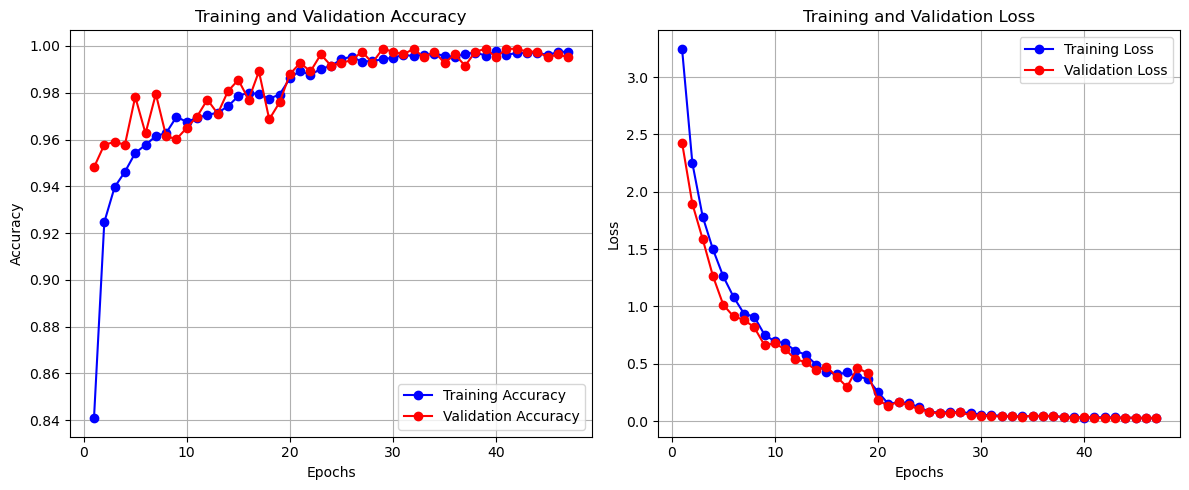

In [16]:
# Load the history from the JSON file
history_path = "history2.json"  # Update with the correct path if needed
with open(history_path, "r") as file:
    history = json.load(file)

# Extract values
epochs = range(1, len(history["accuracy"]) + 1)
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]
train_loss = history["loss"]
val_loss = history["val_loss"]

# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [17]:
pred=model.predict(test_generator)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 320, 320, 3))
  warnings.warn(msg)


11/64 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step

Premature end of JPEG file


15/64 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step

Premature end of JPEG file


21/64 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

Premature end of JPEG file
Premature end of JPEG file


25/64 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

Premature end of JPEG file


33/64 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step

Premature end of JPEG file


64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 320ms/step


## image level performance

In [18]:
import numpy as np
# Ensure predictions are flattened
predictions = pred.flatten()
predictions = (predictions > 0.5).astype(int)
# Convert to NumPy arrays
y_test = test_labels
y_test = np.array(y_test).astype(int)
predictions = np.array(predictions).astype(int)

# Count correct and incorrect predictions
true_positives = np.sum((predictions == 1) & (y_test == 1))
true_negatives = np.sum((predictions == 0) & (y_test == 0))
false_positives = np.sum((predictions == 1) & (y_test == 0))
false_negatives = np.sum((predictions == 0) & (y_test == 1))

# Print results
print(f"True Positives: {true_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
print(f"Calculated Accuracy: {accuracy * 100:.2f}%")

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.2f}")
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions)
print(f"Cohen's Kappa: {kappa:.2f}")


True Positives: 234
True Negatives: 268
False Positives: 0
False Negatives: 4
Calculated Accuracy: 99.21%
Precision: 1.00
Recall: 0.98
F1-Score: 0.99
Cohen's Kappa: 0.98


In [9]:
model=load_model("Bonesmodel.h5");

I0000 00:00:1748733854.744119   26342 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3403 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
pred=model.predict(test_generator)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748733865.389283   26389 service.cc:152] XLA service 0x7bb6b80038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748733865.389305   26389 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-06-01 02:24:25.495198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748733867.007352   26389 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-01 02:24:28.084191: W external/local_xla/x

 2/64 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step  

I0000 00:00:1748733878.565374   26389 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/64 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step

Premature end of JPEG file


15/64 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step

Premature end of JPEG file


21/64 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step

Premature end of JPEG file
Premature end of JPEG file


25/64 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

Premature end of JPEG file


33/64 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step

Premature end of JPEG file


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 309ms/step


In [12]:
predictions = pred.flatten()
predictions = (predictions > 0.5).astype(int)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 